# Figures from Fission Fragment 2

In [1]:
from cheftgp.eft import *
from cheftgp.gaussianprocess import *
from cheftgp.graphs import *
from cheftgp.scattering import *
from cheftgp.utils import *
from cheftgp.potentials import *
from scripts.generator_fns import *

import scipy
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.interpolate import interpn, griddata

from matplotlib.colors import LinearSegmentedColormap

import pandas as pd
import ray
import time

%matplotlib inline

In [2]:
mpl.rc(
        "savefig",
        transparent=False,
        bbox="tight",
        pad_inches=0.05,
        dpi=300,
        format="png",
    )

# Plots of values of $\Lambda_{b}$ and $m_{\rm eff}$ for potentials under test

In [3]:
# imports Pandas tables from another file
from Lambdab_meff_tables import label_table_dict

# chooses string of interest to be passed to dictionary from that file
identifier_str = "unscaled"
lambdab_meff_data = label_table_dict[identifier_str]

lambda_meff_df = pd.DataFrame(lambdab_meff_data, 
        columns = ["Potential", "Cutoff", "Max. order", "Observable(s)", 
                   "Lambdab_mean", "Lambdab_stddev", "meff_mean", "meff_stddev"])

pd.set_option('display.max_rows', len(lambda_meff_df))
display(lambda_meff_df)
pd.reset_option('display.max_rows')

,Potential,Cutoff,Max. order,Observable(s),Lambdab_mean,Lambdab_stddev,meff_mean,meff_stddev
0,SMS,550MeV,N4LO+,ALL2DOBS,560,10,127,2
1,SMS,550MeV,N4LO,ALL2DOBS,450,10,110,3
2,SMS,550MeV,N3LO,ALL2DOBS,380,10,41,2
3,SMS,550MeV,N2LO,ALL2DOBS,370,20,38,2
4,SMS,500MeV,N4LO+,ALL2DOBS,570,10,138,3
5,SMS,500MeV,N4LO,ALL2DOBS,530,10,120,3
6,SMS,500MeV,N3LO,ALL2DOBS,450,10,63,2
7,SMS,500MeV,N2LO,ALL2DOBS,420,20,35,2
8,SMS,450MeV,N4LO+,ALL2DOBS,580,10,154,3
9,SMS,450MeV,N4LO,ALL2DOBS,570,20,130,3


In [4]:
# dicts for plotting
potential_color_dict = {"SMS" : "dodgerblue", "SCS" : "deeppink", 
                       "GT+" : "darkorange", "EMN" : "forestgreen"}
order_marker_dict = {"N4LO+" : "d", "N4LO" : "s", "N3LO" : "^", "N2LO" : "o"}
order_name_order_label_dict = {"N4LO+" : "N$^{4}$LO+", "N4LO" : "N$^{4}$LO", 
                        "N3LO" : "N$^{3}$LO", "N2LO" : "N$^{2}$LO"}
order_name_coeff_name_dict = {"N4LO+" : "c6", "N4LO" : "c5", "N3LO" : "c4", "N2LO" : "c3"}
order_name_coeff_label_dict = {"N4LO+" : "$c_{6}$", "N4LO" : "$c_{5}$", 
                               "N3LO" : "$c_{4}$", "N2LO" : "$c_{3}$"}

In [5]:
# generic linear fit function, with Lambda_b = a * m_eff + b
def Lambdab_meff_linear(x, a, b):
    return a * x + b

In [6]:
# useful little function for eliminating duplicate labels in the legend
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

#### Plots of $\Lambda_{b}$ vs. $m_{\rm eff}$ (as generated by combining all two-dimensional observables) at all orders for all potentials, with lines of best fit

EMN (N2LO): Lambda_b = (-0.3 +/- 0.8) m_eff + (420 +/-  11) MeV
EMN (N3LO): Lambda_b = (0.1 +/- 2.1) m_eff + (383 +/-  75) MeV
EMN (N4LO): Lambda_b = (2.9 +/- 1.9) m_eff + (311 +/- 126) MeV
GT+ (N2LO): Lambda_b = (126.7 +/- 24.0) m_eff + (-2087 +/- 548) MeV
SCS (N2LO): Lambda_b = (24.1 +/- 1.2) m_eff + (-476 +/-  56) MeV
SCS (N3LO): Lambda_b = (0.7 +/- 3.5) m_eff + (436 +/- 249) MeV
SCS (N4LO): Lambda_b = (7.2 +/- 3.2) m_eff + (-199 +/- 374) MeV
SMS (N2LO): Lambda_b = (-23.3 +/- 28.5) m_eff + (1299 +/- 1000) MeV
SMS (N3LO): Lambda_b = (0.5 +/- 0.9) m_eff + (386 +/-  70) MeV
SMS (N4LO): Lambda_b = (6.1 +/- 0.8) m_eff + (-209 +/- 101) MeV
SMS (N4LO+): Lambda_b = (1.2 +/- 0.3) m_eff + (398 +/-  51) MeV


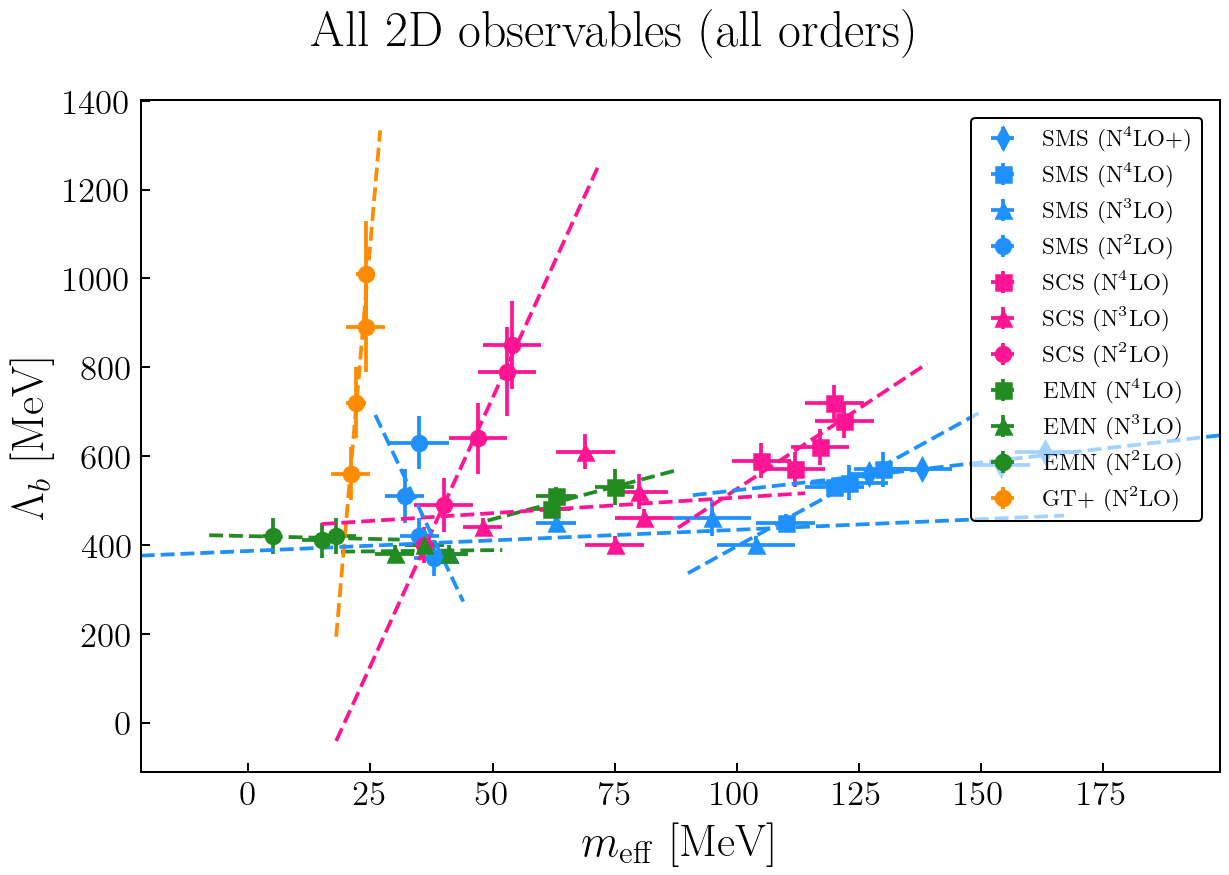

In [7]:
fig_fit_all2dobs_allo, ax_fit_all2dobs_allo = plt.subplots(figsize=(7,5))

for index, row in lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].iterrows():
    # scatter-plots the means and 95% (2 sigma) confidence intervals for the scale values
    ax_fit_all2dobs_allo.errorbar(row["meff_mean"], row["Lambdab_mean"], 
                    xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
                    color = potential_color_dict[row["Potential"]], 
                    label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
                    fmt = order_marker_dict[row["Max. order"]])

# selects only the 2D observables' data
pot_order_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].groupby(['Potential', 'Max. order'])

for (pot, order), row in pot_order_combo:
    # fits the points to a line
    popt, pcov = scipy.optimize.curve_fit(Lambdab_meff_linear, 
                        row["meff_mean"], row["Lambdab_mean"])
    # plots the line of best fit
    ax_fit_all2dobs_allo.plot(
        np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
                    2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
                    100), 
                Lambdab_meff_linear(
                    np.linspace(2 * np.min(row["meff_mean"]) - np.max(row["meff_mean"]), 
                                2 * np.max(row["meff_mean"]) - np.min(row["meff_mean"]), 
                                100), 
                    popt[0], popt[1]), 
                color = potential_color_dict[pot], 
               linestyle = "--", 
               )
    # prints the best fit values
    print(pot + " (" + order + f"): Lambda_b = ({popt[0]:.1f} +/- {np.sqrt(pcov[0, 0]):.1f}) " + \
         f"m_eff + ({popt[1]:3.0f} +/- {np.sqrt(pcov[1, 1]):3.0f}) MeV")

fig_fit_all2dobs_allo.suptitle("All 2D observables (all orders)", fontsize = 20)
ax_fit_all2dobs_allo.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_allo.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_allo.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)

legend_without_duplicate_labels(ax_fit_all2dobs_allo)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit_all2dobs_allo.tight_layout()
plt.show()
fig_fit_all2dobs_allo.savefig('figures2/' + 'Lambdab_vs_meff_all2dobs_allo' + \
                            '_' + identifier_str)

#### Plots of $\Lambda_{b}$ vs. $m_{\rm eff}$ (as generated by combining all two-dimensional observables) at highest order for all potentials

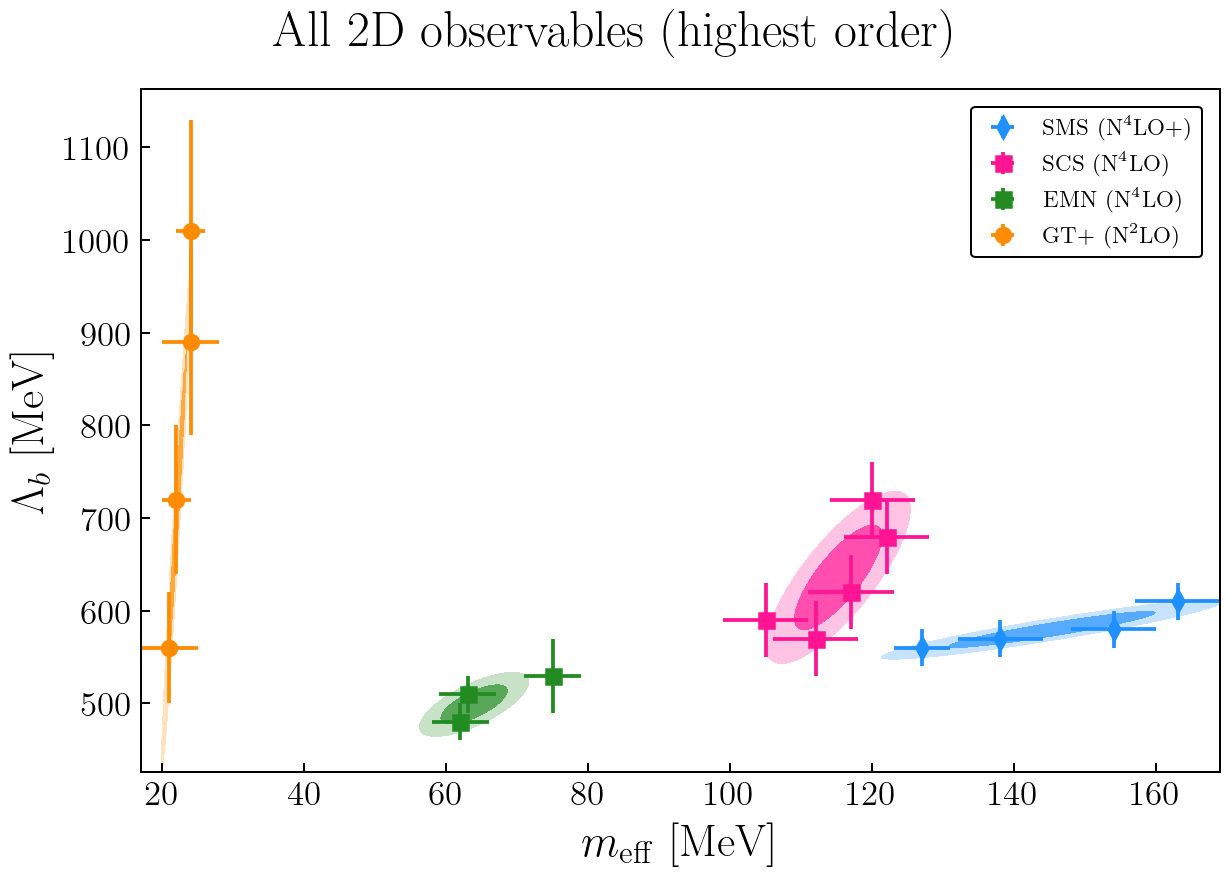

In [8]:
fig_fit_all2dobs_ho, ax_fit_all2dobs_ho = plt.subplots(figsize=(7,5))

# groups information by potential, cutoff, and observable
pot_cutoff_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "ALL2DOBS"].groupby(['Potential', 'Cutoff']).head(1)
for index, row in pot_cutoff_combo.iterrows():
    # scatter-plots the means and 95% (2 sigma) confidence intervals for the scale values
    ax_fit_all2dobs_ho.errorbar(row["meff_mean"], row["Lambdab_mean"], 
                    xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
                    color = potential_color_dict[row["Potential"]], 
                    label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
                    fmt = order_marker_dict[row["Max. order"]])

# grids for plotting the 2D Gaussians
X,Y = np.meshgrid(np.linspace(*ax_fit_all2dobs_ho.get_xlim(), 500),
                  np.linspace(*ax_fit_all2dobs_ho.get_ylim(), 500))
XY = np.array([X.flatten(), Y.flatten()]).T

pot_list = lambda_meff_df['Potential'].unique()

for pot in pot_list:
    X_val_pot = np.array([])
    X_var_pot = np.array([])
    
    pot_combo = lambda_meff_df[(lambda_meff_df["Observable(s)"] == "ALL2DOBS") & (lambda_meff_df["Potential"] == pot)].groupby(['Cutoff']).head(1)
    for index, row in pot_combo.iterrows():
        # appends mean values and weights of MAP Lambda_b and m_eff values
        X_val_pot = np.append(X_val_pot, np.array([row["meff_mean"], row["Lambdab_mean"]]))
        X_var_pot = np.append(X_var_pot, 1 / (row["meff_stddev"]**2 + row["Lambdab_stddev"]**2))
    
    X_val_pot = X_val_pot.reshape(-1, 2)
    
    # calculates the mean values and covariance matrix for that potential's 2D Gaussian
    mean = np.average(X_val_pot, axis=0, weights=X_var_pot)
    data_centered = X_val_pot - mean
    covariance = np.cov(data_centered.T, aweights=X_var_pot)
    
    # defines and evaluates a 2D Gaussian based on those mean and covariance values
    gaussian = multivariate_normal(mean=mean, cov=covariance)
    pdf = gaussian.pdf(XY)

    # plots the 2D Gaussians as contour plots
    ax_fit_all2dobs_ho.tricontourf(X.ravel(), Y.ravel(), pdf, 
        levels = [np.max(pdf) / 3, np.max(pdf) * 2 / 3, np.max(pdf) * 3 / 3], 
        cmap=LinearSegmentedColormap.from_list("white_to_color", 
                ["white", potential_color_dict[pot]]), 
        zorder = -(1 + np.where(pot_list == pot)[0]))

fig_fit_all2dobs_ho.suptitle("All 2D observables (highest order)", fontsize = 20)
ax_fit_all2dobs_ho.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_ho.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
ax_fit_all2dobs_ho.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)

legend_without_duplicate_labels(ax_fit_all2dobs_ho)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit_all2dobs_ho.tight_layout()
plt.show()
fig_fit_all2dobs_ho.savefig('figures2/' + 'Lambdab_vs_meff_all2dobs_ho' + \
                            '_' + identifier_str)

#### Plots of $\Lambda_{b}$ vs. $m_{\rm eff}$ (as generated from total cross section ($\sigma_{\mathrm{tot}}$, or "SGT") data) at highest order for all potentials

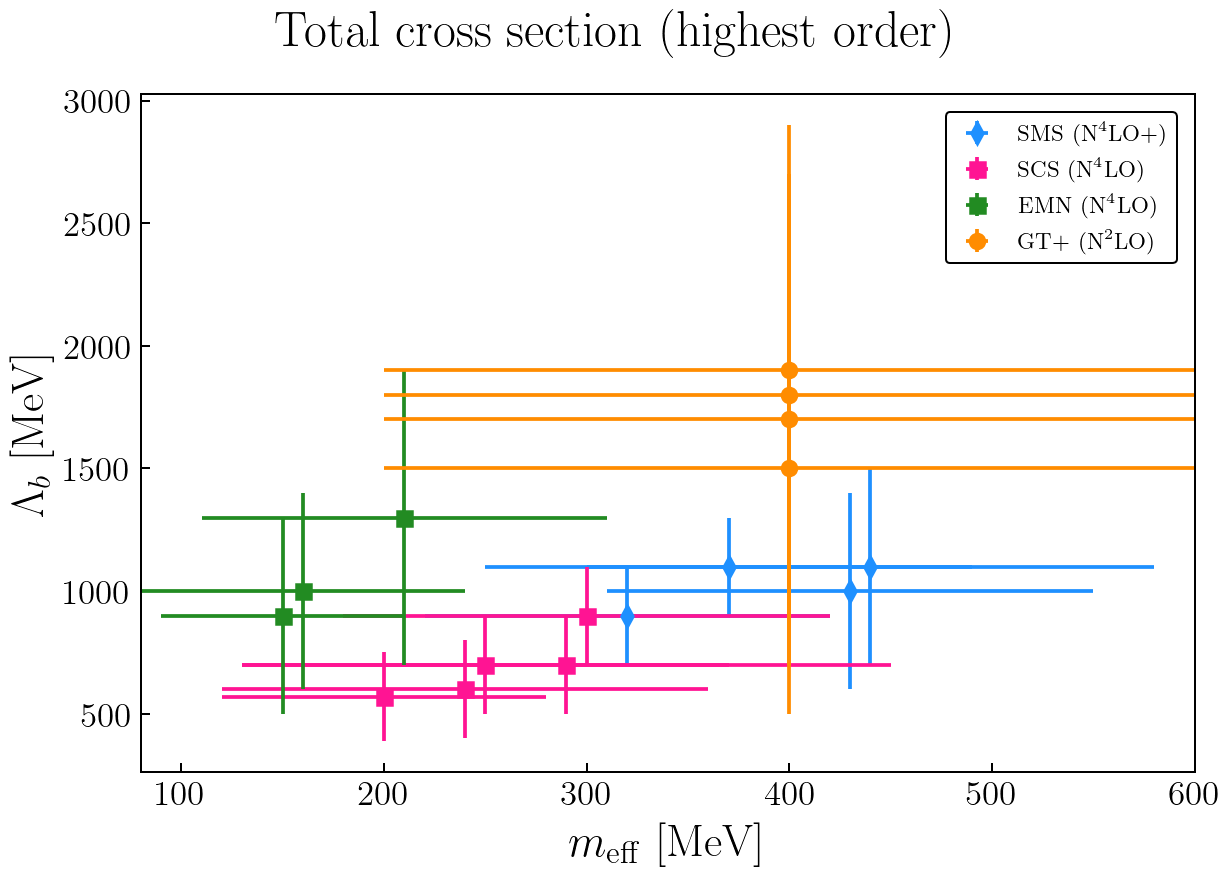

In [9]:
fig_fit_sgt_ho, ax_fit_sgt_ho = plt.subplots(figsize=(7,5))

# groups the data by potential, cutoff, and observable
pot_cutoff_combo = lambda_meff_df[lambda_meff_df["Observable(s)"] == "SGT"].groupby(['Potential', 'Cutoff']).head(1)
for index, row in pot_cutoff_combo.iterrows():
    # scatter-plots the means and 95% (2 sigma) confidence intervals for the scale values
    ax_fit_sgt_ho.errorbar(row["meff_mean"], row["Lambdab_mean"], 
                    xerr = 2 * row["meff_stddev"], yerr = 2 * row["Lambdab_stddev"],
                    color = potential_color_dict[row["Potential"]], 
                    label = r'' + row["Potential"] + ' (' + order_name_order_label_dict[row["Max. order"]] + ')', 
                    fmt = order_marker_dict[row["Max. order"]])

fig_fit_sgt_ho.suptitle("Total cross section (highest order)", fontsize = 20)
ax_fit_sgt_ho.set_xlabel("$m_{\mathrm{eff}}$ [MeV]", fontsize = 18)
ax_fit_sgt_ho.set_ylabel(r"$\Lambda_{b}$ [MeV]", fontsize = 18)
ax_fit_sgt_ho.legend(
            fontsize = 10,
          loc='center left',
          bbox_to_anchor=(1, 0.5),
          handletextpad=0.02,
          borderpad=0.2)

legend_without_duplicate_labels(ax_fit_sgt_ho)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
fig_fit_sgt_ho.tight_layout()
plt.show()
fig_fit_sgt_ho.savefig('figures2/' + 'Lambdab_vs_meff_sgt_ho')

# Plots of length scale and variance by order for different potentials

#### Sets meshes and extracts coefficients from the data for a particular potential and observable

In [10]:
# sets the potential of interest
ScaleScheme = RKE500MeV

In [11]:
# choose energy and angle meshes and training points
t_lab = ScaleScheme.get_data("t_lab")

t_lab_slice_pts = np.array([1, 5, 12, 21, 33, 48, 65, 85, 
                            108, 133, 161, 192, 225, 261, 300, 341])
t_lab_input = E_to_p(E_lab = t_lab, interaction = "np")
X_train_tlab = E_to_p(E_lab = t_lab_slice_pts, 
                     interaction = "np")[:, None]
t_lab_label = r'$p_{\mathrm{rel}}$'
t_lab_name = "prel"
# t_lab_input = t_lab
# t_lab_label = "Lab energy (MeV)"
# t_lab_name = "Elab"

X_tlab = t_lab_input[:, None]
t_lab_subset = X_train_tlab[:, 0]

degrees = ScaleScheme.get_data("degrees")

degrees_slice_pts = np.array([41, 60, 76, 90, 104, 120, 139])
degrees_input = -np.cos(np.radians(degrees))
X_train_deg = -np.cos(np.radians(degrees_slice_pts))[:, None]
degrees_label = r'$-\cos(\theta)$'
degrees_name = "cos"
# degrees_input = degrees
# degrees_label = "\Theta (rad)"
# degrees_name = "deg"

X_deg = degrees_input[:, None]
degrees_subset = X_train_deg[:, 0]

# sets the observable of interest
obs_data_name = "DSG"

# extracts data
if obs_data_name == "AY":
    obs_data = ScaleScheme.get_data("PB")
else:
    obs_data = ScaleScheme.get_data(obs_data_name)

# sets the markdown math-mode label for the observable
obs_data_label_name_dict = {"DSG" : r"$d\sigma / d\Omega$", 
                           "D" : r"$D$", 
                           "AXX" : r"$A_{xx}$", 
                           "AYY" : r"$A_{yy}$", 
                           "A" : r"$A$", 
                           "AY" : r"$A_{y}$", }
obs_data_label = obs_data_label_name_dict[obs_data_name]

# sets values of the breakdown and soft scales
Lambda_b_coeffs = 570
mpi_eff_coeffs = 138

# sets reference scale
if obs_data_name == "DSG":
    yref = obs_data[-1, :, :]
else:
    yref = np.ones(np.shape(obs_data)[1:])

# calculates ratio
p_type = "pprel"
p_grid = p_approx(p_name = p_type, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type = "sum"
ratio = Q_approx(p = p_grid, 
                 Q_parametrization = Q_type, 
                 Lambda_b = Lambda_b_coeffs, 
                 m_pi = mpi_eff_coeffs,
                 single_expansion=False)

# extracts coefficients
coeffs_flattened = gm.coefficients(
            np.reshape(obs_data, (np.shape(obs_data)[0], np.shape(obs_data)[1] * np.shape(obs_data)[2])).T, 
            ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
            ref=np.reshape(yref, np.shape(yref)[0] * np.shape(yref)[1]), 
            orders=ScaleScheme.orders_full)
coeffs_surfaces = np.reshape(coeffs_flattened.T, np.shape(obs_data))

#### Plots of total cross section for given $\Lambda_{b}$ and $m_{\text{eff}}$

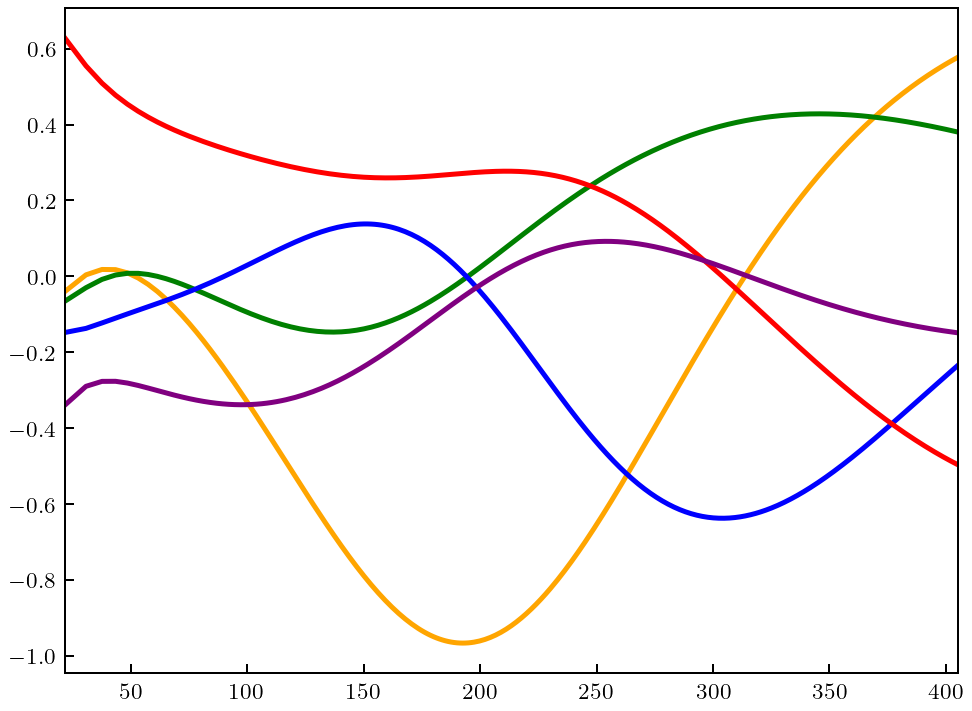

In [12]:
colors_array = ['orange', 'green', 'blue', 'red', 'purple']

fig_sgt, ax_sgt = plt.subplots()

SGT_data = ScaleScheme.get_data("SGT")

# evalutes momentum and ratio grids for plotting
p_grid_sgt = p_approx(p_name = "pprel", 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = [0]).T
ratio_sgt = Q_approx(p = p_grid_sgt, 
                 Q_parametrization = 'sum', 
                 Lambda_b = 695, 
                 m_pi = 250,
                 single_expansion=False)

# sets the reference scale
yref_sgt = SGT_data[-1, :]

# extracts coefficients from the total cross section
SGT_coeffs = gm.coefficients(
            SGT_data.T, 
            ratio=np.reshape(ratio_sgt, np.shape(ratio_sgt)[0] * np.shape(ratio_sgt)[1]),
            ref=np.reshape(yref_sgt, np.shape(yref_sgt)[0]), 
            orders=ScaleScheme.orders_full)
SGT_coeffs = SGT_coeffs.T

# set a limit on x
t_lab_input_limit = t_lab_input[t_lab_input > 0]

for i, curve in enumerate(SGT_coeffs[1:, :]):
    ax_sgt.plot(t_lab_input_limit, curve[np.isin(t_lab_input, t_lab_input_limit)], 
                color = colors_array[i], linewidth = 2)

### Plots ratios of variances for each 2D observable

[]

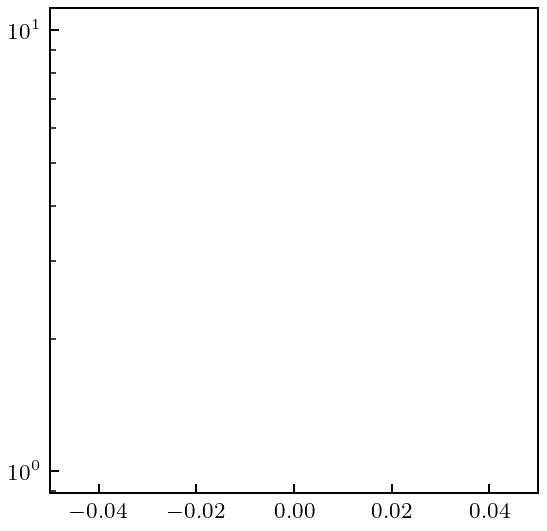

In [13]:
# create figure with n_orders subplots
fig_tlab_var_all_ratio, axs_tlab_var_all_ratio = plt.subplots(1, 1, 
                                                              figsize=(3.5,3.5))
axs_tlab_var_all_ratio.semilogy()

In [14]:
# this section uses all the same input spaces and training points as the rest of the notebook
Lambda_b_vars = Lambda_b_coeffs
mpi_eff_vars = Lambda_b_coeffs

# calculates ratio
p_type_vars = p_type
p_grid_vars = p_approx(p_name = p_type_vars, 
                 prel = E_to_p(E_lab = t_lab, interaction = "np"), 
                 degrees = degrees).T
Q_type_vars = Q_type
ratio_vars = Q_approx(p = p_grid_vars, 
                 Q_parametrization = Q_type_vars, 
                 Lambda_b = Lambda_b_vars, 
                 m_pi = mpi_eff_vars,
                 single_expansion=False)

In [15]:
axs_tlab_var_all_array = np.array([])

# names and labels observbales
obs_data_name_list = ["DSG", "D", "AXX", "AYY", "A", "PB"]
obs_data_label_list = [r"$\frac{d \sigma}{d \Omega}$", 
                       r"$D$", r"$A_{xx}$", r"$A_{yy}$", r"$A$", r"$A_{y}$"]

for idx, obs_data_name_vars in enumerate(obs_data_name_list):
    # extracts data
    obs_data_vars = ScaleScheme.get_data(obs_data_name_vars)
    
    # sets reference scale
    if obs_data_name_vars == "DSG":
        yref_vars = obs_data_vars[-1, :, :]
    else:
        yref_vars = np.ones(np.shape(obs_data_vars)[1:])

    # extracts coefficients
    coeffs_flattened_vars = gm.coefficients(
                np.reshape(obs_data_vars, (np.shape(obs_data_vars)[0], np.shape(obs_data_vars)[1] * np.shape(obs_data_vars)[2])).T, 
                ratio=np.reshape(ratio_vars, np.shape(ratio_vars)[0] * np.shape(ratio_vars)[1]),
                ref=np.reshape(yref_vars, np.shape(yref_vars)[0] * np.shape(yref_vars)[1]), 
                orders=ScaleScheme.orders_full)
    coeffs_surfaces_vars = np.reshape(coeffs_flattened_vars.T, np.shape(obs_data_vars))

    # fits a GP to the coefficients
    for t in t_lab_subset:
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                          length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                               2 * (np.max(degrees_input) - np.min(degrees_input)))
                   ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)

        gp.fit(X_train_deg, 
               np.reshape(coeffs_surfaces_vars[:, np.isin(t_lab_input, t), :].T, 
                          (len(degrees), 
                           np.shape(coeffs_surfaces_vars)[0]))[np.isin(degrees_input, X_train_deg), :])
        pred, std = gp.predict(X_deg, return_std=True)
        # extracts a value of the variance and adds it to an array
        underlying_std_sq = gp.cov_factor_
        axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std_sq)
        
axs_tlab_var_all_array = np.reshape(axs_tlab_var_all_array, 
                                    (len(obs_data_name_list), len(t_lab_subset)))

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:664: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  optima = np.array(optima)
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.72964355e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.64309458e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 35, 'nit': 4, 'warnflag

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.04091664e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 39, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.67279388e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.62071951e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b te

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([1.13254428e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 37, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-5.29630024e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.4055803e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b term

In [16]:
# for each observable, plots the ratio of the largest variance extracted to the smallest, 
# with options for excluding data from the sample
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, :]) / np.min(axs_tlab_var_all_array[l, :]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 'o', 
    edgecolors = 'green',
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 25\,\mathrm{MeV}, m_{\pi}^{\star}, \Lambda_{b}^{\star})$',
#     edgecolors = 'green', 
#     label = r'2D ALLOBS, all $p_{\mathrm{rel}} > 25\,\mathrm{MeV}$',
    linewidths = 2,
    s = 90, 
    facecolors = 'none')
axs_tlab_var_all_ratio.scatter(list(range(len(obs_data_name_list))), 
    [np.max(axs_tlab_var_all_array[l, 4:]) / np.min(axs_tlab_var_all_array[l, 4:]) for l in range(len(axs_tlab_var_all_array))], 
    marker = 's', 
#     c = 'red', 
#     label = r'OPAAT, $p_{\mathrm{rel}} > 125\,\mathrm{MeV}$', 
    c = 'green', 
    label = r'$Q_{\mathrm{sum}}(p_{\mathrm{rel}} \geq 125\,\mathrm{MeV}, m_{\pi}^{\prime}, \Lambda_{b}^{\prime})$',
    s = 90)
axs_tlab_var_all_ratio.legend(loc = 'upper right', 
                              fontsize = 10,
                              handletextpad=0.02,
                              borderpad=0.2)

axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)
axs_tlab_var_all_ratio.tick_params(axis = 'y', labelsize = 10)
axs_tlab_var_all_ratio.set_xlim(-1, len(obs_data_name_list))
axs_tlab_var_all_ratio.set_ylim(0.9, 160)

# saves figures
fig_tlab_var_all_ratio.savefig('figures2/' + 'var_ratios' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string)

C:\Users\pjmil\AppData\Local\Temp\ipykernel_23304\2519844871.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs_tlab_var_all_ratio.set_xticklabels([""] + obs_data_label_list + [""], fontsize = 10)


## Plots of scattering-angle length scale and variance by order

In [17]:
# function for finding the rms value of a 1D function over a domain
# useful for calculating the rough size of 1D dimensionless coefficient functions
def rms_1d(coeff, x):
    return np.sqrt(np.trapz(coeff**(2) / (np.max(x) - np.min(x)), x))

In [18]:
# unit test for rms_1d
# finds the rms value of sine over one wavelength, namely the famous result 2^-1/2
print(rms_1d(np.sin(np.linspace(0, np.pi, 200)), np.linspace(0, np.pi, 200)))

0.7071067811865475


In [19]:
# choose colormap and fix to different energies
cmap_tlab = mpl.cm.viridis
norm_tlab = mpl.colors.Normalize(vmin=np.min(t_lab_input), vmax=np.max(t_lab_input))

C:\Users\pjmil\AppData\Local\Temp\ipykernel_23304\1866396150.py:80: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_tlab_ls.flat)[o].scatter(t,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_23304\1866396150.py:87: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_tlab_var.flat)[o].scatter(t,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated

The average rms value for each coefficient is:
c2 : 0.5967746195616644 +/- 0.30534361059749
c3 : 0.426394684556212 +/- 0.2760041307072368
c4 : 0.4630775924551215 +/- 0.28018201707980933
c5 : 0.617869156727119 +/- 0.4321421917940408
c6 : 0.5717340235325777 +/- 0.27142816773637113


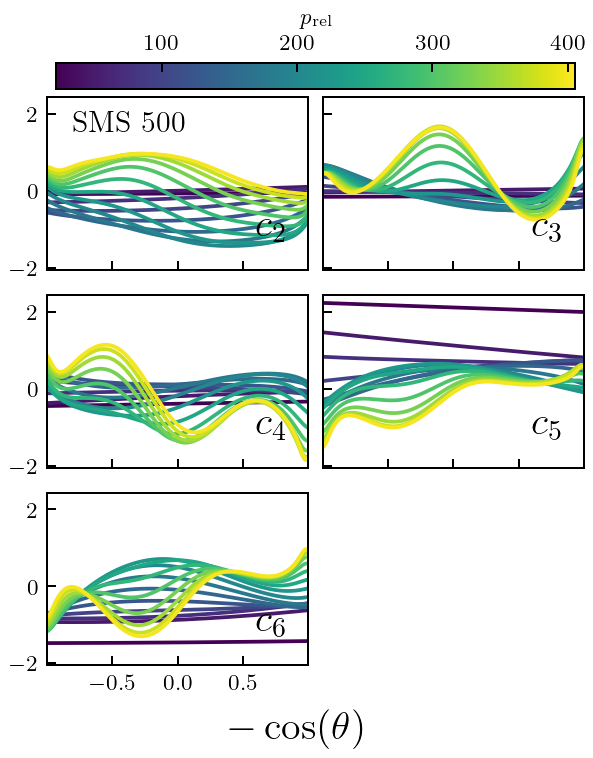

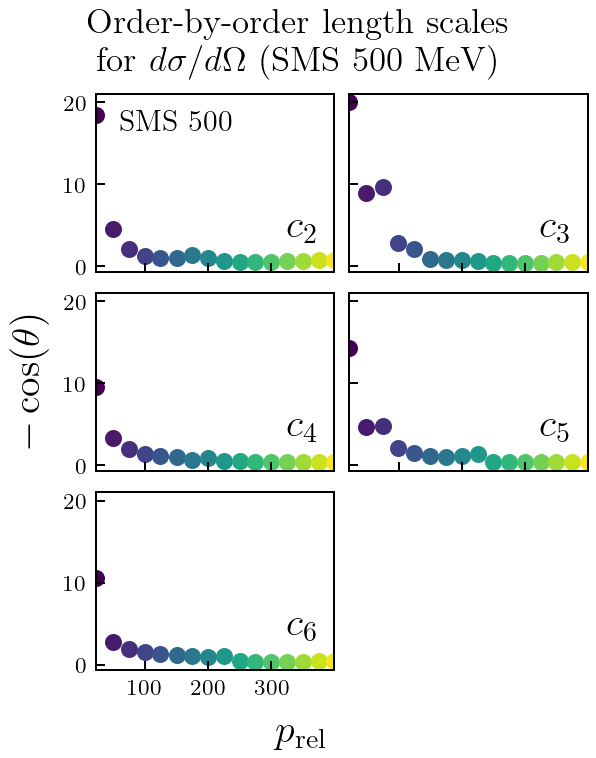

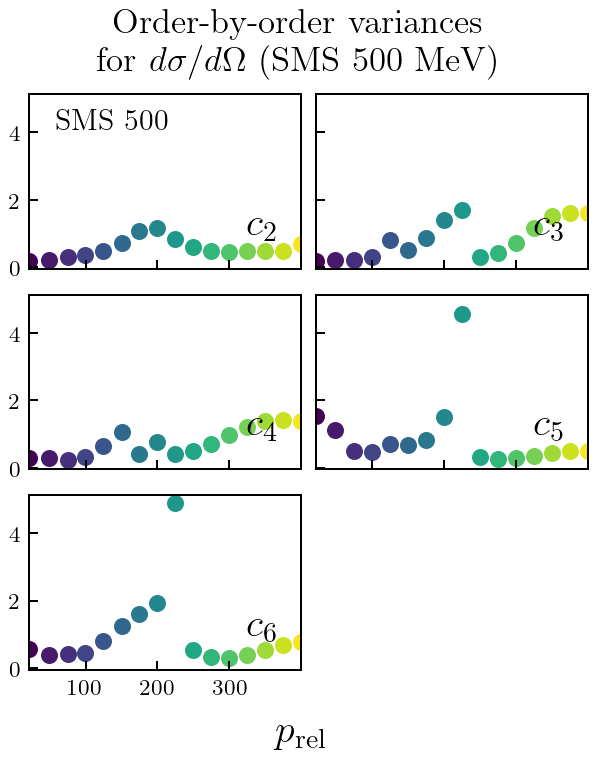

In [20]:
# number of vertical plots, which comes from the number of orders
n_vert = int(np.ceil((np.shape(coeffs_surfaces)[0] - 1) / 2))

# create figure with n_orders subplots
fig_tlab_coeffs, axs_tlab_coeffs = plt.subplots(
                        n_vert, 
                        2, sharex = True, sharey=True, 
                        figsize=(3.3, 1.4 * n_vert), 
                        layout='constrained')
# fig_tlab_coeffs.suptitle('Order-by-order coefficients\nfor ' + obs_data_label + " (" + 
#              ScaleScheme.potential_string + " " + 
#              ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + ")", size = 14)

# create figure with n_orders subplots
fig_tlab_ls, axs_tlab_ls = plt.subplots(
                        n_vert, 
                        2, sharex = True, sharey=True, 
                        figsize=(3.3, 1.4 * n_vert), 
                        layout='constrained')
fig_tlab_ls.supxlabel(t_lab_label, size = 16)
fig_tlab_ls.supylabel(degrees_label, size = 16)
fig_tlab_ls.suptitle('Order-by-order length scales\nfor ' + obs_data_label + " (" + 
             ScaleScheme.potential_string + " " + 
             ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + ")", size = 14)

# create figure with n_orders subplots
fig_tlab_var, axs_tlab_var = plt.subplots(
                        n_vert, 
                        2, sharex = True, sharey=True, 
                        figsize=(3.3, 1.4 * n_vert), 
                        layout='constrained')
fig_tlab_var.supxlabel(t_lab_label, size = 16)
fig_tlab_var.suptitle('Order-by-order variances\nfor ' + obs_data_label + " (" + 
             ScaleScheme.potential_string + " " + 
             ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + ")", size = 14)

rms_tlab_coeffs = np.zeros((np.shape(coeffs_surfaces)[0] - 1, np.shape(t_lab_subset)[0]))

# plot at each energy in mesh
for o in range(np.shape(coeffs_surfaces)[0] - 1):
    # writes the order of each coefficient on the plots
    (axs_tlab_coeffs.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_coeffs.flat)[o].transAxes, 
                       size = 16)
    (axs_tlab_ls.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_ls.flat)[o].transAxes, 
                       size = 16)
    (axs_tlab_var.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_tlab_var.flat)[o].transAxes, 
                       size = 16)
        
    for t_idx, t in enumerate(t_lab_subset):
        (axs_tlab_coeffs.flat)[o].plot(degrees_input, 
                    coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        # calculates the coefficient's rms value
        rms_tlab_coeffs[o, t_idx] = rms_1d((coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T)[:, 0], 
                                  degrees_input)
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                      length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                           10 * (np.max(degrees_input) - np.min(degrees_input)))
               ) + WhiteKernel(1e-5, noise_level_bounds='fixed'),
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        
        # fits the GP
        gp.fit(X_train_deg, 
               (coeffs_surfaces[o + 1, np.isin(t_lab_input, t), :].T)[np.isin(degrees_input, X_train_deg)])
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_tlab_ls.flat)[o].scatter(t, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))
        
        # extracts the variance
        pred, std = gp.predict(X_deg, return_std=True)
        underlying_std_sq = gp.cov_factor_
        (axs_tlab_var.flat)[o].scatter(t, 
                    underlying_std_sq, 
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t))

# writes the scheme and scale on the upper-left-most plot
(axs_tlab_coeffs.flat)[0].text(0.1, 0.8, 
       ScaleScheme.potential_string + " " + \
            ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", "").replace("fm", ""), 
       transform=(axs_tlab_coeffs.flat)[0].transAxes, 
       size = 12)
(axs_tlab_ls.flat)[0].text(0.1, 0.8, 
       ScaleScheme.potential_string + " " + \
            ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", "").replace("fm", ""), 
       transform=(axs_tlab_ls.flat)[0].transAxes, 
       size = 12)
(axs_tlab_var.flat)[0].text(0.1, 0.8, 
       ScaleScheme.potential_string + " " + \
            ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", "").replace("fm", ""), 
       transform=(axs_tlab_var.flat)[0].transAxes, 
       size = 12)

# prints the average coefficient rms value for each order
print("The average rms value for each coefficient is:")
for o in range(np.shape(coeffs_surfaces)[0] - 1):
    print("c" + str(ScaleScheme.orders_full[o + 1]) + " : " + \
          str(np.average(rms_tlab_coeffs[o, :])) + " +/- " + \
          str(np.std(rms_tlab_coeffs[o, :]))
         )

# deletes extraneous Axes objects from the plot
if n_vert * 2 != np.shape(coeffs_surfaces)[0] - 1:
    fig_tlab_coeffs.delaxes((axs_tlab_coeffs.flat)[-1])
    fig_tlab_ls.delaxes((axs_tlab_ls.flat)[-1])
    fig_tlab_var.delaxes((axs_tlab_var.flat)[-1])

# plots the color bar for reference
fig_tlab_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab), 
#             ax = (axs_tlab_coeffs.flat)[-1],
            ax = axs_tlab_coeffs[0],
            location = 'top',
            orientation='horizontal', 
            label=t_lab_label)

# plots the overall x-axis label
fig_tlab_coeffs.supxlabel(degrees_label, size = 16)

# saves figures
# fig_tlab_coeffs.tight_layout()
fig_tlab_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
# fig_tlab_ls.tight_layout()
fig_tlab_ls.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
# fig_tlab_var.tight_layout()
fig_tlab_var.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

## Plots of scattering-angle length scale and variance over all orders

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.47399507e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 40, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([5.19680616e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 4, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([6.39708305e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 39, 'nit': 7, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b ter

scaling = 1.3461640775578956 +/- 0.6220186409299068
fractional offset = 0.9004724446108958 +/- 0.2805752982939454
magnitude = 0.5902031607905514 +/- 0.07928555034529858


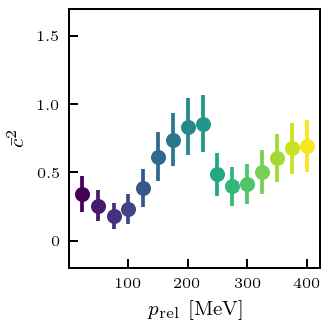

In [21]:
axs_tlab_var_all_array = np.array([])
axs_tlab_var_all_stddev_array = np.array([])

def lorentzian(x, k, delta, M):
    R = np.max(x) - np.min(x)
    return M * (1 + (k / R * (x - delta * R))**(2))**(-1)

# selects which observables to include and what to call them
obs_var_name_array_name = obs_data_name
obs_var_name_array = [obs_var_name_array_name]
obs_var_label_array = [obs_data_label]
# obs_var_name_array_name = "ALLOBS"
# obs_var_name_array = ["DSG", "D", "AXX", "AYY", "A", "AY"]
# obs_var_label_array = ["all 2D obs."]

# create figure with n_orders subplots
fig_tlab_var_all, axs_tlab_var_all = plt.subplots(1, 1, 
                                                  sharex = True, sharey=True, 
                                                  figsize=(2.0, 2.0))

# sets axis limits, labels, and ticks
axs_tlab_var_all.set_xlim(0, 423)
axs_tlab_var_all.set_xlabel(t_lab_label + " [MeV]", size = 8)
axs_tlab_var_all.set_xticks(ticks = [100, 200, 300, 400], 
                   labels = [100, 200, 300, 400], 
                   fontsize=6)
axs_tlab_var_all.set_ylim(-0.2, 1.7)
axs_tlab_var_all.set_ylabel(r"$\bar{c}^{2}$", size = 8)
axs_tlab_var_all.set_yticks(ticks = [0, 0.5, 1.0, 1.5], 
                   labels = [0, 0.5, 1.0, 1.5], 
                   fontsize=6)
# axs_tlab_var_all.set_title('All-orders variances for ' + obs_var_label_array[0] + " (" + 
#              ScaleScheme.potential_string + 
#              " " + ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + 
#              ")", size = 8)
# axs_tlab_var_all.semilogx()
# axs_tlab_var_all.semilogy()

for ovna_idx, ovna in enumerate(obs_var_name_array):
    # extracts data
    if ovna == "AY":
        ovna_data = ScaleScheme.get_data("PB")
    else:
        ovna_data = ScaleScheme.get_data(ovna)

    # sets reference scale
    if ovna == "DSG":
        ovna_yref = ovna_data[-1, :, :]
    else:
        ovna_yref = np.ones(np.shape(ovna_data)[1:])

    coeffs_flattened_ovna = gm.coefficients(
                np.reshape(ovna_data, (np.shape(ovna_data)[0], np.shape(ovna_data)[1] * np.shape(ovna_data)[2])).T, 
                ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
                ref=np.reshape(ovna_yref, np.shape(ovna_yref)[0] * np.shape(ovna_yref)[1]), 
                orders=ScaleScheme.orders_full)
    coeffs_surfaces_ovna = np.reshape(coeffs_flattened_ovna.T, np.shape(ovna_data))

    # plots at each energy in mesh
    for t in t_lab_subset:
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=0.25 * (np.max(degrees_input) - np.min(degrees_input)),
                          length_scale_bounds=(0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                               10 * (np.max(degrees_input) - np.min(degrees_input)))
                   ) + WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        
        # fits the GP
        gp.fit(X_train_deg, 
               np.reshape(coeffs_surfaces_ovna[:, np.isin(t_lab_input, t), :].T, 
                          (len(degrees), 
                           np.shape(coeffs_surfaces_ovna)[0]))[np.isin(degrees_input, X_train_deg), :])
        
        # extracts the variance and assesses its error bars as scaled-inverse-chi-squared-distributed
        underlying_std_sq = gp.cov_factor_
        stddev_underlying_std = np.sqrt(underlying_std_sq * 2 / (gp.df_ - 4))
    
        # appends variance values to an array
        axs_tlab_var_all_array = np.append(axs_tlab_var_all_array, underlying_std_sq)
        axs_tlab_var_all_stddev_array = np.append(axs_tlab_var_all_stddev_array, stddev_underlying_std)

# reshapes arrays in preparation for plotting
axs_tlab_var_all_array = np.reshape(axs_tlab_var_all_array, 
                                    (len(obs_var_name_array), len(t_lab_subset)))
axs_tlab_var_all_stddev_array = np.reshape(axs_tlab_var_all_stddev_array, 
                                    (len(obs_var_name_array), len(t_lab_subset)))

# plots variances with error bars
for t in t_lab_subset:
    axs_tlab_var_all.errorbar(t, 
                    (np.prod(axs_tlab_var_all_array, axis = 0)**(1 / len(obs_var_name_array)))[np.isin(t_lab_subset, t)], 
                    yerr = (np.sum(axs_tlab_var_all_stddev_array, axis = 0) / len(obs_var_name_array))[np.isin(t_lab_subset, t)],
                    c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t), 
                    fmt = 'o', markersize = 5)

# fits variances to Lorentzian
popt, pcov = curve_fit(lorentzian, t_lab_subset, 
                                    np.prod(axs_tlab_var_all_array, axis = 0)**(1 / len(obs_var_name_array)), 
                                    sigma = np.sum(axs_tlab_var_all_stddev_array, axis = 0) / len(obs_var_name_array)
                                     )
# # plots the line of best fit
# axs_tlab_var_all.plot(t_lab_input, 
#             lorentzian(t_lab_input, *popt), 
#             color = "blue", 
#             )

# prints the best fit values
print("scaling = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])))
print("fractional offset = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])))
print("magnitude = " + str(popt[2]) + " +/- " + str(np.sqrt(pcov[2, 2])))

# saves figure
fig_tlab_var_all.tight_layout()
fig_tlab_var_all.savefig('figures2/' + 'var' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_var_name_array_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

In [22]:
# data on power-law best-fit magnitude and exponent from all 2D observables
# SMS 550 MeV
# N4LO+: magnitude = 136.31452457117496 +/- 35.44318778971489
# N4LO+: power = -1.0363265518407314 +/- 0.045699188906517016
# SMS 500 MeV
# N4LO+: magnitude = 110.38610891472231 +/- 25.6684777333181
# N4LO+: power = -0.9875970832439643 +/- 0.04053653784036533
# SMS 450 MeV
# N4LO+: magnitude = 38.19408072840246 +/- 17.659824238289897
# N4LO+: power = -0.8024283678441405 +/- 0.08028607622786836
# SMS 400 MeV
# N4LO+: magnitude = 63.79903072508313 +/- 25.699274619673744
# N4LO+: power = -0.8815931795132642 +/- 0.0705260404980459

# SCS 0.8 fm
# N4LO: magnitude = 122.07994455986669 +/- 22.55700350100443
# N4LO: power = -1.0097171264516989 +/- 0.03238951272768408
# SCS 0.9 fm
# N4LO: magnitude = 117.37031330064788 +/- 28.349683253030936
# N4LO: power = -0.9980675448601319 +/- 0.0433561331292563
# SCS 1.0 fm
# N4LO: magnitude = 72.5625319864772 +/- 23.095929926864656
# N4LO: power = -0.9019699010026988 +/- 0.05633523187690033
# SCS 1.1 fm
# N4LO: magnitude = 93.72055654413269 +/- 31.460124007080807
# N4LO: power = -0.9458189790189132 +/- 0.05800855746457256
# SCS 1.2 fm
# N4LO: magnitude = 131.8536016840254 +/- 30.3490502765213
# N4LO: power = -1.0176496056964328 +/- 0.04031905801825545

# EMN 550 MeV
# N4LO: magnitude = 24.75813341261366 +/- 14.14708979414239
# N4LO: power = -0.7040133993281966 +/- 0.10175694345244762
# EMN 500 MeV
# N4LO: magnitude = 19.8970976939396 +/- 9.758112975901614
# N4LO: power = -0.6551357914606488 +/- 0.08837973939490716
# EMN 450 MeV
# N4LO: magnitude = 22.428283429318775 +/- 7.15919926241424
# N4LO: power = -0.6567562053980777 +/- 0.056090587759907495

# GT+ 0.9 fm
# N2LO: magnitude = 68.08580544504628 +/- 28.65307613130318
# N2LO: power = -0.921116638924384 +/- 0.07875715148620108
# GT+ 1.0 fm
# N2LO: magnitude = 82.28518799192493 +/- 30.5099531215581
# N2LO: power = -0.9612841432438141 +/- 0.06823115359934773
# GT+ 1.1 fm
# N2LO: magnitude = 85.0644145272933 +/- 28.649511842932775
# N2LO: power = -0.9696125927430508 +/- 0.06205983125624193
# GT+ 1.2 fm
# N2LO: magnitude = 105.12180354039467 +/- 31.853677779886343
# N2LO: power = -1.0196564436996844 +/- 0.05558899204133019

In [23]:
# data on Lorentzian best-fit scaling and fractional offset from all 2D observables
# SMS 550 MeV
# scaling = 2.180578189879298 +/- 0.2776858311235583
# fractional offset = 0.7645130078000336 +/- 0.033328910121863
# SMS 500 MeV
# scaling = 1.7188719477574015 +/- 0.17382531092630896
# fractional offset = 0.7058988894681305 +/- 0.025911280593021942
# SMS 450 MeV
# scaling = 1.7114240008687003 +/- 0.19334460263780384
# fractional offset = 0.6441933002725452 +/- 0.027509474596582702
# SMS 400 MeV
# scaling = 2.1012008191566323 +/- 0.16444071680727737
# fractional offset = 0.617875384963154 +/- 0.017119690574439364

# SCS 0.8 fm
# scaling = 2.7310082094836936 +/- 0.26888461070562425
# fractional offset = 0.7109117440625596 +/- 0.018746800359119714
# SCS 0.9 fm
# scaling = 2.0456471816070128 +/- 0.14189796195096252
# fractional offset = 0.6986603106870393 +/- 0.015182978328935039
# SCS 1.0 fm
# scaling = 1.917235299495727 +/- 0.11527308537729314
# fractional offset = 0.6878097374589209 +/- 0.01597279371727367
# SCS 1.1 fm
# scaling = 2.0221812909445678 +/- 0.15009921263668127
# fractional offset = 0.6484363295581509 +/- 0.01800478888690344
# SCS 1.2 fm
# scaling = 2.16088536996295 +/- 0.20837506910316259
# fractional offset = 0.61114567410409 +/- 0.020753281281024445

# EMN 550 MeV
# scaling = -3.405343742669119 +/- 0.46267056106624604
# fractional offset = 0.7048958835581299 +/- 0.02733748287177218
# EMN 500 MeV
# scaling = -3.034641578872837 +/- 0.3976466604798504
# fractional offset = 0.6899524700622449 +/- 0.02434033339686811
# EMN 450 MeV
# scaling = -2.2881128336748495 +/- 0.2817921722984444
# fractional offset = 0.6109677260445364 +/- 0.023133290537437946

# GT+ 0.9 fm
# scaling = 1.5878840730236992 +/- 0.2812067540854969
# fractional offset = 0.3556758437877054 +/- 0.07079482598619423
# GT+ 1.0 fm
# scaling = 1.5907412954411626 +/- 0.2098830543834126
# fractional offset = 0.3182789212605225 +/- 0.06213722810786929
# GT+ 1.1 fm
# scaling = -1.1190360690584382 +/- 0.2254166167897737
# fractional offset = 0.18474017445107696 +/- 0.16320236123711213
# GT+ 1.2 fm
# scaling = -6.645978360681249e-07 +/- inf
# fractional offset = 0.7801262999327864 +/- inf

In [24]:
# list of potentials for consideration
ScaleSchemeQ_list = [ScaleScheme]

# sets random variables for Bayesian statistical calculations
ls_deg_vals = np.linspace(0.01 * (np.max(degrees_input) - np.min(degrees_input)), 
                          10 * (np.max(degrees_input) - np.min(degrees_input)), 
                          500, dtype=np.dtype('f4'))
# cbar_vals = np.linspace(0.01, 4, 100, dtype=np.dtype('f4'))
mesh_cart_tlabslice = gm.cartesian(np.log(ls_deg_vals))
# mesh_cart_tlabslice = gm.cartesian(np.log(cbar_vals), np.log(ls_deg_vals))

LsDegVariable = RandomVariable(var=ls_deg_vals,
                            user_val=None,
                            name='lsdeg',
                            label="\ell_{\Theta}",
                            units="",
                            ticks=[],
                            logprior=np.zeros(len(ls_deg_vals)),
                            logprior_name="noprior",
                            marg_bool=True)
# CbarVariable = RandomVariable(var=cbar_vals,
#                             user_val=1,
#                             name='cbar',
#                             label="\overline{c}^{2}",
#                             units="",
#                             ticks=[],
#                             logprior=np.zeros(len(cbar_vals)),
#                             logprior_name="noprior",
#                             marg_bool=False)

variables_array = np.array([LsDegVariable])
# variables_array = np.array([CbarVariable, LsDegVariable])

# selects which observables to include and what to call them
plot_obs_list = [[obs_data_name]]
obs_name_grouped_list = [obs_data_name]
obs_labels_grouped_list = [obs_data_label]
mesh_cart_grouped_list = [[mesh_cart_tlabslice]]
# # ALLOBS for angle input spaces
# plot_obs_list = [["DSG", "D", "AXX", "AYY", "A", "AY"]]
# obs_name_grouped_list = ["ALLOBS"]
# obs_labels_grouped_list = ["all 2D obs."]
# mesh_cart_grouped_list = [[mesh_cart_tlabslice, mesh_cart_tlabslice, mesh_cart_tlabslice, 
#                           mesh_cart_tlabslice, mesh_cart_tlabslice, mesh_cart_tlabslice, ]]

# creates a new ratio and log_likelihood function
def ratio_fn_new(X, p_grid_train, p_param, p_shape, Q_param, mpi_var, p, lambda_var, 
                 single_expansion = False):
    """
    Function for interpolating between the input space and the ratio across that input space.

    Parameters
    ----------
    X (array) : array of input-space values. These are never called but must be passed here anyway due to GSUM.
    p_grid_train : array of momenta for evaluating ratio
    p_param (str) : type of p parametrization.
        Can be "Qofprel", "Qofqcm", or "Qofpq"
    p_shape (tuple) : shape for momentum before calculating ratio.
    Q_param (str) : type of Q parametrization.
        Can be "smoothmax", "max", or "sum".
    mpi_var (float) : value of the (effective) pion mass (in MeV) for calculating the ratio.
    lambda_var (float) : value of the breakdown scale (in MeV) for calculating the ratio.
    single_expansion (bool) : if True, then mpi_var is set to 0 within Q_approx
        Default : False
    """
    return Q_approx(p = p, 
                    Q_parametrization=Q_param, Lambda_b = lambda_var, 
                    m_pi = mpi_var, single_expansion=single_expansion)

@ray.remote
def log_likelihood_new(gp_fitted,
                   mesh_points,
                   log_likelihood_fn_kwargs
                   ):
    """
    Calculates the log-likelihood for a set of inputs.

    Parameters
    ----------
    gp_fitted (TruncationGP) : fitted Gaussian process object.
    mesh_points (float array) : array of tuples of random variables at which to evaluate the log-likelihood.
        Must be in the order (lambda_var, all length scales, mpi_var).
    log_likelihood_fn_kwargs (dict) : keyword arguments for log_likelihood.
    """
    return [gp_fitted.log_marginal_likelihood([pt[n] for n in range(len(pt))],
                                              **{**log_likelihood_fn_kwargs}

                                              ) for pt in mesh_points]

# accounts for nonstationarity in the length scale
def scaling_fn(X,
               ls_array,
               ):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    ls = np.array([])
    try:
        for pt_idx, pt in enumerate(X):
            ls = np.append(ls, ls_array)
    except:
        pass

    ls = np.reshape(ls, X_shape)

    return ls

scaling_fn_kwargs={}

# accounts for nonstationarity in the variance
def cbar_fn(X,
               cbar_array = np.array([1]),
               ):
    X_shape = np.shape(X)
    X = np.reshape(X, (np.prod(X_shape[:-1]), ) + (X_shape[-1], ))
    cbar = np.array([])
    try:
        for pt_idx, pt in enumerate(X):
            cbar = np.append(cbar, cbar_array)
    except:
        pass

    cbar = np.reshape(cbar, X_shape[:-1])

    return cbar

cbar_fn_kwargs={}

2024-11-20 16:30:06,310	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 11.589818
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 11.868932291743725
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 1.8466124172507656


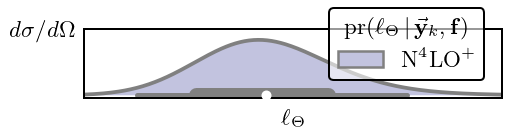

c:\users\pjmil\research\modern_nn_potentials\cheftgp\graphs.py:334: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


[11.589818   11.86893229  1.84661242]


2024-11-20 16:30:17,735	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 3.3027835
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 3.4340963062677505
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.5099578252027143


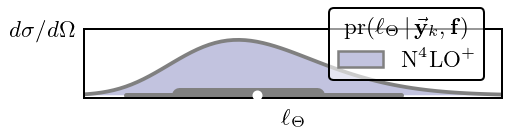

[3.30278349 3.43409631 0.50995783]


2024-11-20 16:30:28,968	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 2.3419678
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 2.316069904137784
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.2729431758559062


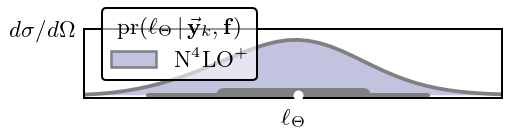

[2.34196782 2.3160699  0.27294318]


2024-11-20 16:30:40,224	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 1.5412883
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 1.5687984681721472
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.1412923555424581


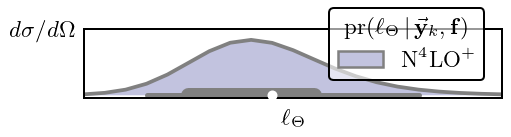

[1.54128826 1.56879847 0.14129236]


2024-11-20 16:30:51,699	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 1.3411183
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 1.3037297839366047
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.17000222136999893


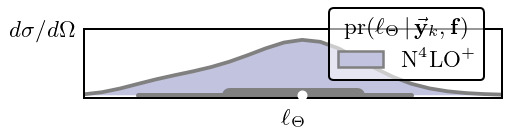

[1.34111834 1.30372978 0.17000222]


2024-11-20 16:31:02,952	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.94077855
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 1.031482916641479
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.17272917388803086


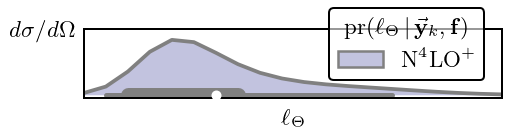

[0.94077855 1.03148292 0.17272917]


2024-11-20 16:31:14,278	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.94077855
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.9790946950975032
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.10967808311860382


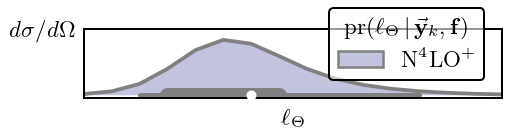

[0.94077855 0.9790947  0.10967808]


2024-11-20 16:31:25,644	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.90074456
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.8812697955064424
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.1033388292804204


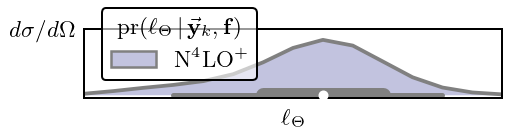

[0.90074456 0.8812698  0.10333883]


2024-11-20 16:31:36,957	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.5804727
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.5636316155466364
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.04520269439440408


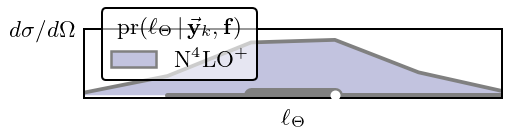

[0.58047271 0.56363162 0.04520269]


2024-11-20 16:31:48,159	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.46037075
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.4574352463731012
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.033352897429081874


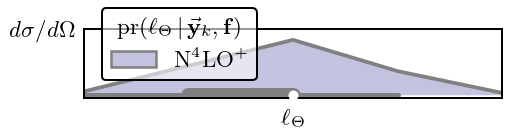

[0.46037075 0.45743525 0.0333529 ]


2024-11-20 16:31:59,771	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.3803028
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.39122709163825886
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.032025884183526136


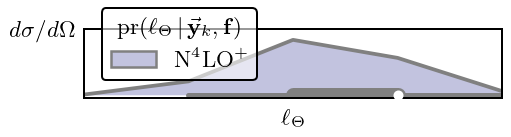

[0.38030279 0.39122709 0.03202588]


2024-11-20 16:32:11,192	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.3803028
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.3728077840020865
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.030086418981689237


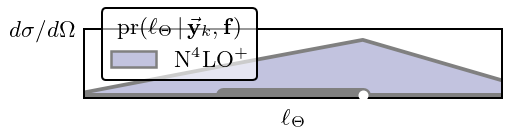

[0.38030279 0.37280778 0.03008642]


2024-11-20 16:32:22,766	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.3803028
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.381615948320158
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.02904737247730019


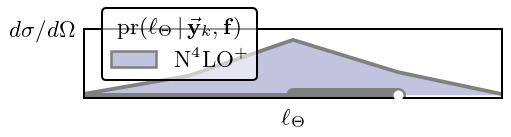

[0.38030279 0.38161595 0.02904737]


2024-11-20 16:32:34,319	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.3803028
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.39653605602313063
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.03349485662693442


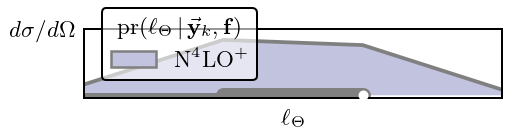

[0.38030279 0.39653606 0.03349486]


2024-11-20 16:32:45,613	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.42033678
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.40735326786830267
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.032462617896951845


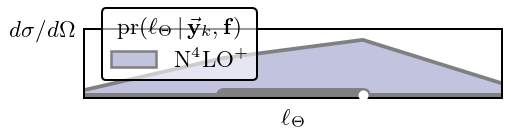

[0.42033678 0.40735327 0.03246262]


2024-11-20 16:32:57,181	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lsdeg: MAP value = 0.42033678
Observable $d\sigma / d\Omega$, variable lsdeg: mean = 0.4114660085949962
Observable $d\sigma / d\Omega$, variable lsdeg: std. dev. = 0.03147278901195099


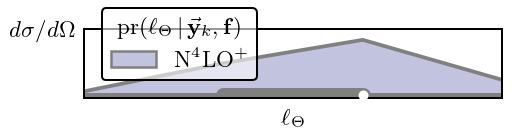

[0.42033678 0.41146601 0.03147279]


In [25]:
ell_fit_pts = np.array([])
ell_fit_stddev = np.array([])
cbar_fit_pts = np.array([])
cbar_fit_stddev = np.array([])

orders_ell = 1
orders_cbar = orders_ell

# calculates posterior pdfs for the scattering-angle length scale and extracts values for 
# the MAP, mean, and variance
for elfp, pfp in zip(t_lab_slice_pts, E_to_p(t_lab_slice_pts, interaction = 'np')):
    ratio_fn=ratio_fn_new
    ratio_fn_kwargs={
        "p_param": p_type,
        "Q_param": Q_type,
        "p" : pfp,
        "mpi_var": mpi_eff_coeffs,
        "lambda_var": Lambda_b_coeffs,
        "single_expansion": False,
    }
    log_likelihood_fn=log_likelihood_new
    log_likelihood_fn_kwargs={
        "p_param": p_type,
        "Q_param": Q_type,
        "p" : pfp,
        "mpi_var": mpi_eff_coeffs,
        "lambda_var": Lambda_b_coeffs,
        "single_expansion": False,
    }
    
    stats_array, _ = generate_posteriors(
        scale_scheme_bunch_array=ScaleSchemeQ_list,
        Q_param_method_array=[Q_type],
        p_param_method_array=[p_type],
        input_space_deg=[degrees_name],
        input_space_tlab=[t_lab_name],
        Elab_slice = elfp,
        t_lab_train_pts=np.array([1, 12, 33, 65, 108, 161, 225, 300]),
        degrees_train_pts=degrees_slice_pts,
        orders_from_ho=orders_ell,
        orders_excluded=[],
        orders_names_dict=None,
        orders_labels_dict=None,
        length_scale_list=[NSKernelParam(0.2 * (np.max(degrees_input) - np.min(degrees_input)), 
                                        [0.05 * (np.max(degrees_input) - np.min(degrees_input)), 
                                        1 * (np.max(degrees_input) - np.min(degrees_input))])],
        length_scale_fixed = False,
        cbar_list = [NSKernelParam(1.0, [0.1, 10])],
        cbar_fixed = True,
        m_pi_eff=mpi_eff_coeffs,
        Lambdab=Lambda_b_coeffs,
        print_all_classes=False,
        savefile_type="png",

        plot_posterior_curvewise_bool=True,
        plot_marg_curvewise_bool=True,
        plot_corner_curvewise_bool=False,
        use_data_curvewise_bool=False,
        save_data_curvewise_bool=False,
        save_posterior_curvewise_bool=False,

        plot_obs_list = plot_obs_list,
        obs_name_grouped_list = obs_name_grouped_list,
        obs_labels_grouped_list = obs_labels_grouped_list,
        mesh_cart_grouped_list = mesh_cart_grouped_list,
        variables_array_curvewise = variables_array,
        
        ratio_fn_posterior = ratio_fn,
        ratio_fn_kwargs_posterior = ratio_fn_kwargs,
        log_likelihood_fn_posterior = log_likelihood_fn,
        log_likelihood_fn_kwargs_posterior = log_likelihood_fn_kwargs,
        
        cbar_fn = cbar_fn,
        cbar_fn_kwargs = cbar_fn_kwargs,
        scaling_fn = scaling_fn,
        scaling_fn_kwargs = scaling_fn_kwargs,

        plot_posterior_pointwise_bool=False,
        save_posterior_pointwise_bool=False,

        variables_array_pointwise = np.array([0]),

        filename_addendum="",
    )
    
    print(stats_array)
    ell_fit_pts = np.append(ell_fit_pts, stats_array[[i % 3 == 0 for i in range(np.shape(stats_array)[0])]])
    ell_fit_stddev = np.append(ell_fit_stddev, stats_array[[i % 3 == 2 for i in range(np.shape(stats_array)[0])]])
#     cbar_fit_pts = np.append(cbar_fit_pts, stats_array[[i % 3 == 0 for i in range(np.shape(stats_array)[0])]])
#     cbar_fit_stddev = np.append(cbar_fit_stddev, stats_array[[i % 3 == 2 for i in range(np.shape(stats_array)[0])]])
# ell_fit_stddev = np.zeros(np.shape(ell_fit_pts))

N4LO+: magnitude = 344.0647077044565 +/- 141.5642440143623
N4LO+: power = -1.173439917592483 +/- 0.07569530118848171



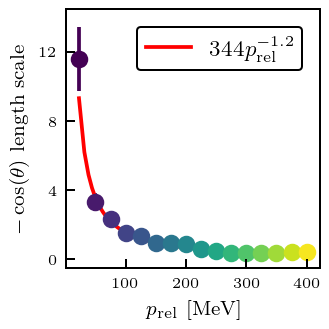

In [26]:
from sklearn.linear_model import LinearRegression

# dicts for orders
orders_labels_dict = {6: r'N$^{4}$LO+', 5: r'N$^{4}$LO',
                    4: r'N$^{3}$LO', 3: r'N$^{2}$LO', 2: r'NLO'}
orders_names_dict = {6: r'N4LO+', 5: r'N4LO', 4: r'N3LO', 3: r'N2LO', 2: r'NLO'}

# sets fitting functions
def power(x, a, b):
    return a * x**b

for ss_idx in range(len(ScaleSchemeQ_list)):
    # create figure with n_orders subplots
    fig_tlab_ls_all, axs_tlab_ls_all = plt.subplots(1, 1, sharex = True, sharey = True, 
                                                    figsize=(2.0, 2.0))
    
    # sets the axis limits, labels, and ticks
    axs_tlab_ls_all.set_xlim(0, 423)
    axs_tlab_ls_all.set_xlabel(t_lab_label + ' [MeV]', size = 8)
    axs_tlab_ls_all.set_xticks(ticks = [100, 200, 300, 400], 
               labels = [100, 200, 300, 400], 
               fontsize=6)
    axs_tlab_ls_all.set_ylim(-0.5, 14.5)
    axs_tlab_ls_all.set_ylabel(degrees_label + ' length scale', size = 8)
    axs_tlab_ls_all.set_yticks(ticks = [0, 4, 8, 12], 
               labels = [0, 4, 8, 12], 
               fontsize=6)
#     axs_tlab_ls_all.set_title('All-orders length scales for ' + obs_labels_grouped_list[0] \
#                 + " (" + ScaleScheme.potential_string +  " " + 
#                 ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + ")"\
#                 , size = 8)
    # axs_tlab_ls_all.semilogx()
    # axs_tlab_ls_all.semilogy()

    for o_idx in range(orders_ell):
        idx_mask = [i % (orders_ell * len(ScaleSchemeQ_list)) == 
                 (o_idx + ss_idx * orders_ell) for i in range(len(ell_fit_pts))]

        # scatter-plots the means and (1-sigma) confidence intervals for the length scale
        axs_tlab_ls_all_array = ell_fit_pts[idx_mask]
        axs_tlab_ls_all_stddev_array = ell_fit_stddev[idx_mask]
        for t in t_lab_subset:
            axs_tlab_ls_all.errorbar(t, 
                        axs_tlab_ls_all_array[np.isin(t_lab_subset, t)], 
                        yerr = axs_tlab_ls_all_stddev_array[np.isin(t_lab_subset, t)],
                        c = mpl.cm.ScalarMappable(norm=norm_tlab, cmap=cmap_tlab).to_rgba(t), 
                        fmt = 'o', 
                       zorder = o_idx)
            
        # fits the points to a power law
        popt, pcov = curve_fit(power, t_lab_subset, 
                                            axs_tlab_ls_all_array, 
                                            sigma = axs_tlab_ls_all_stddev_array,
                                             )

        # plots the line of best fit
        axs_tlab_ls_all.plot(t_lab_input, 
                    power(t_lab_input, popt[0], popt[1]), 
                    color = "red", 
#                     label = rf"$({popt[0]:2.0f} \pm {np.sqrt(pcov[0, 0]):2.0f}) x \wedge ({popt[1]:1.1f} \pm {np.sqrt(pcov[1, 1]):1.1f})$", 
                    label = rf"${popt[0]:2.0f} p_{{\mathrm{{rel}}}}^{{{popt[1]:1.1f}}}$", 
                    zorder = o_idx)
        # prints the best fit values
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_ell + o_idx + 1] + ": magnitude = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])))
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_ell + o_idx + 1] + ": power = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])) + "\n")

    axs_tlab_ls_all.legend(fontsize = 9, loc = 'upper right')
    fig_tlab_ls_all.tight_layout()

    # saves figure
    fig_tlab_ls_all.savefig('figures2/' + 'ls' + '_' + 'tlab_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_name_grouped_list[0] + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

## Plots of lab-energy length scale and variance by order

In [27]:
# choose colormap and fix to different energies
cmap_deg = mpl.cm.magma
norm_deg = mpl.colors.Normalize(vmin=np.min(degrees_input), vmax=np.max(degrees_input))

C:\Users\pjmil\AppData\Local\Temp\ipykernel_23304\2703918404.py:78: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_deg_ls.flat)[o].scatter(d,
C:\Users\pjmil\AppData\Local\Temp\ipykernel_23304\2703918404.py:84: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  (axs_deg_var.flat)[o].scatter(d,
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated a

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.1960809e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 33, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([3.2660781e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 35, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.53641759e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b term

The average rms value for each coefficient is:
c2 : 0.6937305273298608 +/- 0.10860691766111072
c3 : 0.4468135976442107 +/- 0.22728879760567616
c4 : 0.49320712582850723 +/- 0.16615514889895297
c5 : 0.6374332531416176 +/- 0.057063202700165225
c6 : 0.5428708127510502 +/- 0.09260307091945862


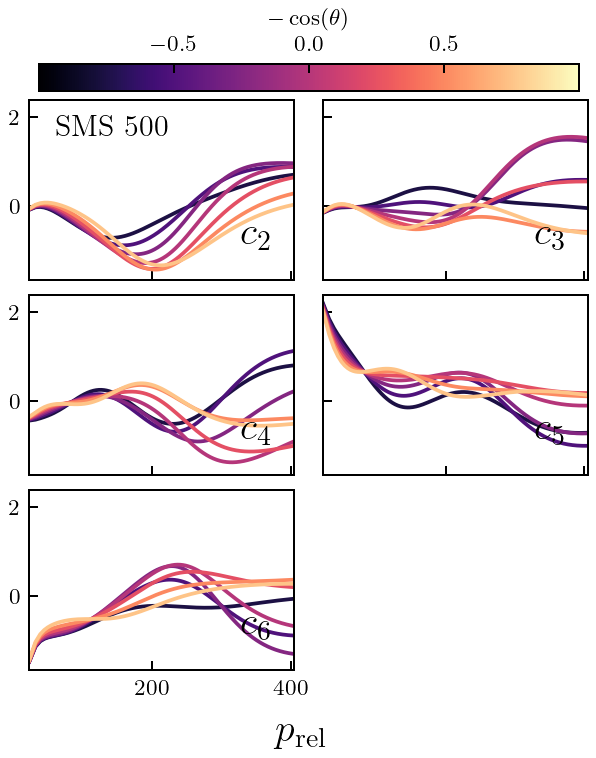

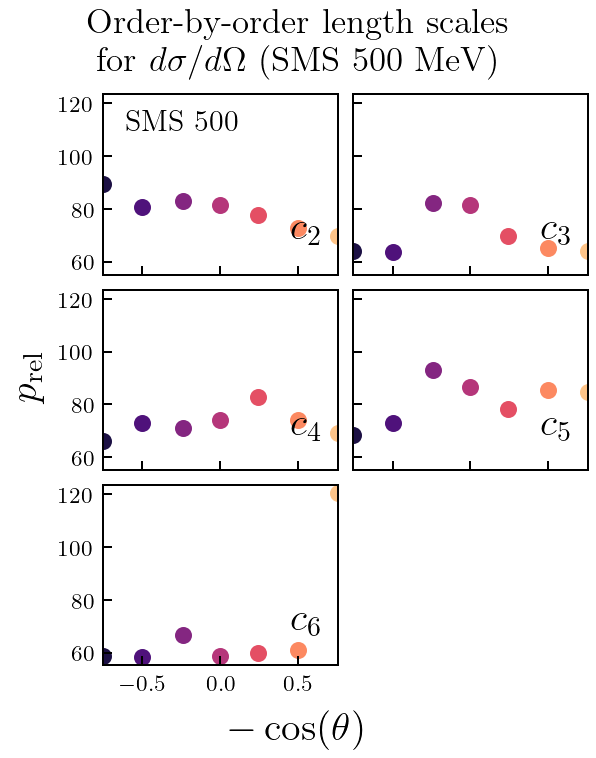

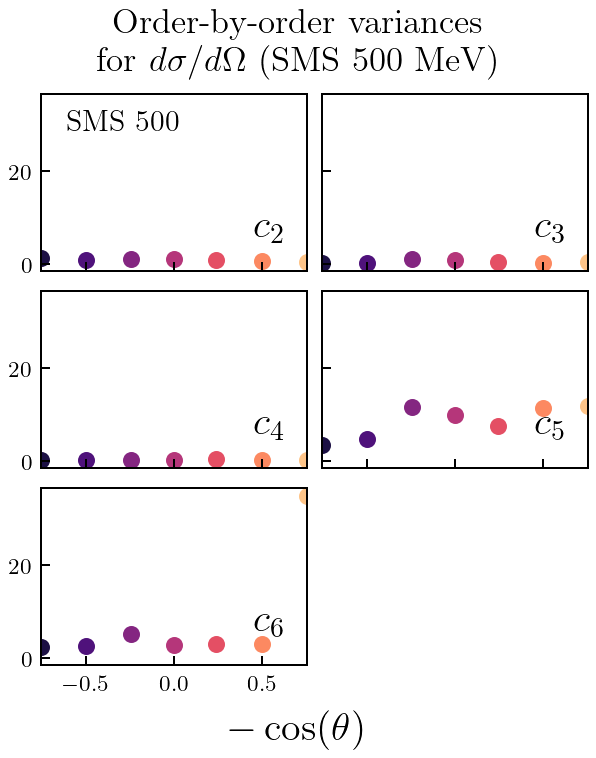

In [28]:
# number of vertical plots, which comes from the number of orders
n_vert = int(np.ceil((np.shape(coeffs_surfaces)[0] - 1) / 2))

# create figure with n_orders subplots
fig_deg_coeffs, axs_deg_coeffs = plt.subplots(n_vert, 
                            2, sharex = True, sharey=True, 
                            figsize=(3.3, 1.4 * n_vert), 
                            layout='constrained')
# fig_deg_coeffs.suptitle('Order-by-order coefficients\nfor ' + obs_data_label + " (" + 
#              ScaleScheme.potential_string + " " + 
#              ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + ")", size = 14)

# create figure with n_orders subplots
fig_deg_ls, axs_deg_ls = plt.subplots(n_vert, 
                            2, sharex = True, sharey=True, 
                            figsize=(3.3, 1.4 * n_vert), 
                            layout='constrained')
fig_deg_ls.supxlabel(degrees_label, size = 16)
fig_deg_ls.supylabel(t_lab_label, size = 16)
fig_deg_ls.suptitle('Order-by-order length scales\nfor ' + obs_data_label + " (" + 
             ScaleScheme.potential_string + " " + 
             ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + ")", size = 14)

# create figure with n_orders subplots
fig_deg_var, axs_deg_var = plt.subplots(n_vert, 
                            2, sharex = True, sharey=True, 
                            figsize=(3.3, 1.4 * n_vert), 
                            layout='constrained')
fig_deg_var.supxlabel(degrees_label, size = 16)
fig_deg_var.suptitle('Order-by-order variances\nfor ' + obs_data_label + " (" + 
             ScaleScheme.potential_string + " " + 
             ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + ")", size = 14)

rms_deg_coeffs = np.zeros((np.shape(coeffs_surfaces)[0] - 1, np.shape(degrees_subset)[0]))

# plots at each angle in mesh
for o in range(np.shape(coeffs_surfaces)[0] - 1):
    # writes the order of each coefficient on the plots
    (axs_deg_coeffs.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_deg_coeffs.flat)[o].transAxes, 
                       size = 16)
    (axs_deg_ls.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_deg_ls.flat)[o].transAxes, 
                       size = 16)
    (axs_deg_var.flat)[o].text(0.8, 0.2, 
                       rf'$c_{{{ScaleScheme.orders_full[o + 1]}}}$', 
                       transform=(axs_deg_var.flat)[o].transAxes, 
                       size = 16)
        
    for d_idx, d in enumerate(degrees_subset):
        # plots coefficients
        (axs_deg_coeffs.flat)[o].plot(t_lab_input, 
                    coeffs_surfaces[o + 1, :, np.isin(degrees_input, d)].T, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        
        # calculates the coefficient's rms value
        rms_deg_coeffs[o, d_idx] = rms_1d((coeffs_surfaces[o + 1, :, np.isin(degrees_input, d)].T)[:, 0], 
                                  t_lab_input)
        
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=60,
                      length_scale_bounds=(12, 300)) + \
                      WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        # fits a GP to the coefficients at the training points
        gp.fit(X_train_tlab, 
               (coeffs_surfaces[o + 1, :, np.isin(degrees_input, d)].T)[np.isin(t_lab_input, X_train_tlab)])
        # extracts the length scale from the GP
        ls_fit = np.exp(gp.kernel_.theta)
        (axs_deg_ls.flat)[o].scatter(d, 
                    ls_fit, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))
        # extracts the variance from the GP
        pred, std = gp.predict(X_tlab, return_std=True)
        underlying_std_sq = gp.cov_factor_
        (axs_deg_var.flat)[o].scatter(d, 
                    underlying_std_sq, 
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d))

# writes the scheme and scale on the upper-left-most plot
(axs_deg_coeffs.flat)[0].text(0.1, 0.8, 
       ScaleScheme.potential_string + " " + \
            ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", "").replace("fm", ""), 
       transform=(axs_deg_coeffs.flat)[0].transAxes, 
       size = 12)
(axs_deg_ls.flat)[0].text(0.1, 0.8, 
       ScaleScheme.potential_string + " " + \
            ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", "").replace("fm", ""), 
       transform=(axs_deg_ls.flat)[0].transAxes, 
       size = 12)
(axs_deg_var.flat)[0].text(0.1, 0.8, 
       ScaleScheme.potential_string + " " + \
            ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", "").replace("fm", ""), 
       transform=(axs_deg_var.flat)[0].transAxes, 
       size = 12)

# prints the average coefficient rms value for each order
print("The average rms value for each coefficient is:")
for o in range(np.shape(coeffs_surfaces)[0] - 1):
    print("c" + str(ScaleScheme.orders_full[o + 1]) + " : " + \
          str(np.average(rms_deg_coeffs[o, :])) + " +/- " + \
          str(np.std(rms_deg_coeffs[o, :]))
         )

# deletes extraneous Axes objects from the plot
if n_vert * 2 != np.shape(coeffs_surfaces)[0] - 1:
    fig_deg_coeffs.delaxes((axs_deg_coeffs.flat)[-1])        
    fig_deg_ls.delaxes((axs_deg_ls.flat)[-1])
    fig_deg_var.delaxes((axs_deg_var.flat)[-1])

# plots the color bar for reference
fig_deg_coeffs.colorbar(mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg), 
            ax = axs_deg_coeffs[0],
            location = 'top',
            orientation='horizontal', 
            label=degrees_label)

# plots the overall x-axis label
fig_deg_coeffs.supxlabel(t_lab_label, size = 16)

# saves figures
# fig_deg_coeffs.tight_layout()
fig_deg_coeffs.savefig('figures2/' + 'coeffs' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
# fig_deg_ls.tight_layout()
fig_deg_ls.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)
# fig_deg_var.tight_layout()
fig_deg_var.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'orderbyorder' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_data_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

## Plots of lab-energy length scale and variance over all orders

C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([0.00014169]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 33, 'nit': 3, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00013378]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 36, 'nit': 5, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated abnormally with the "
C:\Users\pjmil\anaconda3\envs\modern-nn-potentials\lib\site-packages\gsum\models.py:897: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-6.95188089e-05]), 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 41, 'nit': 6, 'warnflag': 2}
  warnings.warn("fmin_l_bfgs_b terminated

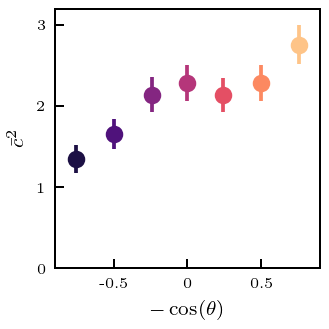

In [29]:
axs_deg_var_all_array = np.array([])
axs_deg_var_all_stddev_array = np.array([])

# selects which observables to include and what to call them
obs_var_name_array_name = obs_data_name
obs_var_name_array = [obs_var_name_array_name]
obs_var_label_array = [obs_data_label]
# obs_var_name_array_name = "ALLOBS"
# obs_var_name_array = ["DSG", "D", "AXX", "AYY", "A", "AY"]
# obs_var_label_array = ["all 2D obs."]

# create figure with n_orders subplots
fig_deg_var_all, axs_deg_var_all = plt.subplots(1, 1, sharex = True, sharey=True, 
                                                figsize=(2.0, 2.0))

# sets x-axis limits, labels, and ticks
axs_deg_var_all.set_xlim(-0.9, 0.9)
axs_deg_var_all.set_xlabel(degrees_label, size = 8)
axs_deg_var_all.set_xticks(ticks = [-0.5, 0, 0.5], 
                   labels = [-0.5, 0, 0.5], 
                   fontsize=6)
axs_deg_var_all.set_ylim(0.2, 3.2)
axs_deg_var_all.set_ylabel(r"$\bar{c}^{2}$", size = 8)
axs_deg_var_all.set_yticks(ticks = [0, 1, 2, 3], 
                   labels = [0, 1, 2, 3], 
                   fontsize=6)
# axs_deg_var_all.set_title('All-orders variances for ' + obs_var_label_array[0] + " (" + 
#              ScaleScheme.potential_string + " " + 
#              ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + ")", size = 8)
# axs_deg_var_all.semilogx()
# axs_deg_var_all.semilogy()

for ovna_idx, ovna in enumerate(obs_var_name_array):
    # extracts data
    if ovna == "AY":
        ovna_data = ScaleScheme.get_data("PB")
    else:
        ovna_data = ScaleScheme.get_data(ovna)

    # sets reference scale
    if ovna == "DSG":
        ovna_yref = ovna_data[-1, :, :]
    else:
        ovna_yref = np.ones(np.shape(ovna_data)[1:])

    coeffs_flattened_ovna = gm.coefficients(
                np.reshape(ovna_data, (np.shape(ovna_data)[0], np.shape(ovna_data)[1] * np.shape(ovna_data)[2])).T, 
                ratio=np.reshape(ratio, np.shape(ratio)[0] * np.shape(ratio)[1]),
                ref=np.reshape(ovna_yref, np.shape(ovna_yref)[0] * np.shape(ovna_yref)[1]), 
                orders=ScaleScheme.orders_full)
    coeffs_surfaces_ovna = np.reshape(coeffs_flattened_ovna.T, np.shape(ovna_data))

    # plots at each angle in mesh
    for d in degrees_subset:
        gp = gm.ConjugateGaussianProcess(
            RBF(length_scale=60,
                      length_scale_bounds=(12, 300)) + \
                      WhiteKernel(1e-5, noise_level_bounds='fixed'), 
            center=0, 
            disp=0, 
            df=1,
            scale=1, 
            n_restarts_optimizer=100, 
            random_state=None,
            sd=None)
        # fits the GP
        gp.fit(X_train_tlab, 
               np.reshape(coeffs_surfaces_ovna[:, :, np.isin(degrees_input, d)].T, 
                         (len(t_lab), 
                         np.shape(coeffs_surfaces_ovna)[0]))[np.isin(t_lab_input, X_train_tlab), :])

        # extracts the variance and assesses its error bars as scaled-inverse-chi-squared-distributed
        pred, std = gp.predict(X_tlab, return_std=True)
        underlying_std_sq = gp.cov_factor_
        stddev_underlying_std = np.sqrt(underlying_std_sq * 2 / (gp.df_ - 4))

        # appends variance values to an array
        axs_deg_var_all_array = np.append(axs_deg_var_all_array, underlying_std_sq)
        axs_deg_var_all_stddev_array = np.append(axs_deg_var_all_stddev_array, stddev_underlying_std)

# reshapes the arrays for plotting
axs_deg_var_all_array = np.reshape(axs_deg_var_all_array, 
                                    (len(obs_var_name_array), len(degrees_subset)))
axs_deg_var_all_stddev_array = np.reshape(axs_deg_var_all_stddev_array, 
                                    (len(obs_var_name_array), len(degrees_subset)))

# plots variances with error bars
for d in degrees_subset:
    axs_deg_var_all.errorbar(d, 
                    (np.prod(axs_deg_var_all_array, axis = 0)**(1 / len(obs_var_name_array)))[np.isin(degrees_subset, d)], 
                    yerr = (np.sum(axs_deg_var_all_stddev_array, axis = 0) / len(obs_var_name_array))[np.isin(degrees_subset, d)],
                    c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d), 
                    fmt = 'o')

# saves figures
fig_deg_var_all.tight_layout()
fig_deg_var_all.savefig('figures2/' + 'var' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_var_name_array_name + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

In [30]:
ScaleSchemeQ_list = [ScaleScheme]

# sets random variables for Bayesian statistical calculations
ls_tlab_vals = np.linspace(1, 150, 
                          500, dtype=np.dtype('f4'))

mesh_cart_degslice = gm.cartesian(np.log(ls_tlab_vals))

LsTlabVariable = RandomVariable(var=ls_tlab_vals,
                            user_val=None,
                            name='lstlab',
                            label="\ell_{T}",
                            units="MeV",
                            ticks=[],
                            logprior=np.zeros(len(ls_tlab_vals)),
                            logprior_name="noprior",
                            marg_bool=True)
variables_array = np.array([LsTlabVariable])

# selects which observables to include and what to call them
plot_obs_list = [[obs_data_name]]
obs_name_grouped_list = [obs_data_name]
obs_labels_grouped_list = [obs_data_label]
mesh_cart_grouped_list = [[mesh_cart_degslice]]
# # ALLOBS for angle input spaces
# plot_obs_list = [["DSG", "D", "AXX", "AYY", "A", "AY"]]
# obs_name_grouped_list = ["ALLOBS"]
# obs_labels_grouped_list = ["all 2D obs."]
# mesh_cart_grouped_list = [[mesh_cart_degslice, mesh_cart_degslice, mesh_cart_degslice, 
#                           mesh_cart_degslice, mesh_cart_degslice, mesh_cart_degslice, ]]

ell_fit_pts = np.array([])
ell_fit_stddev = np.array([])

orders_ell = 1

# creates a new ratio and log_likelihood function
def ratio_fn_new(X, p_grid_train, p_param, p_shape, Q_param, mpi_var, p, lambda_var, 
                 single_expansion = False):
    """
    Function for interpolating between the input space and the ratio across that input space.

    Parameters
    ----------
    X (array) : array of input-space values. These are never called but must be passed here anyway due to GSUM.
    p_grid_train : array of momenta for evaluating ratio
    p_param (str) : type of p parametrization.
        Can be "Qofprel", "Qofqcm", or "Qofpq"
    p_shape (tuple) : shape for momentum before calculating ratio.
    Q_param (str) : type of Q parametrization.
        Can be "smoothmax", "max", or "sum".
    mpi_var (float) : value of the (effective) pion mass (in MeV) for calculating the ratio.
    lambda_var (float) : value of the breakdown scale (in MeV) for calculating the ratio.
    single_expansion (bool) : if True, then mpi_var is set to 0 within Q_approx
        Default : False
    """
    return Q_approx(p = p, 
                    Q_parametrization=Q_param, Lambda_b = lambda_var, 
                    m_pi = mpi_var, single_expansion=single_expansion)

@ray.remote
def log_likelihood_new(gp_fitted,
                   mesh_points,
                   log_likelihood_fn_kwargs
                   ):
    """
    Calculates the log-likelihood for a set of inputs.

    Parameters
    ----------
    gp_fitted (TruncationGP) : fitted Gaussian process object.
    mesh_points (float array) : array of tuples of random variables at which to evaluate the log-likelihood.
        Must be in the order (lambda_var, all length scales, mpi_var).
    log_likelihood_fn_kwargs (dict) : keyword arguments for log_likelihood.
    """
    return [gp_fitted.log_marginal_likelihood([pt[n] for n in range(len(pt))],
                                              **{**log_likelihood_fn_kwargs}

                                              ) for pt in mesh_points]

2024-11-20 16:33:58,193	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lstlab: MAP value = 64.601204
Observable $d\sigma / d\Omega$, variable lstlab: mean = 64.66146332364676
Observable $d\sigma / d\Omega$, variable lstlab: std. dev. = 4.631465772427434


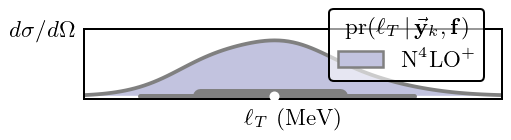

2024-11-20 16:34:09,602	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lstlab: MAP value = 65.198395
Observable $d\sigma / d\Omega$, variable lstlab: mean = 65.7584279390641
Observable $d\sigma / d\Omega$, variable lstlab: std. dev. = 4.6041534205585695


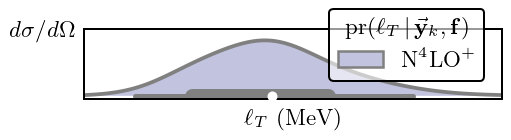

2024-11-20 16:34:21,033	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lstlab: MAP value = 64.8998
Observable $d\sigma / d\Omega$, variable lstlab: mean = 66.14633505915755
Observable $d\sigma / d\Omega$, variable lstlab: std. dev. = 4.932203649455663


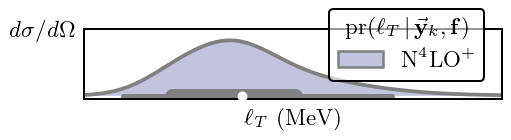

2024-11-20 16:34:32,547	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lstlab: MAP value = 67.288574
Observable $d\sigma / d\Omega$, variable lstlab: mean = 69.82489661570594
Observable $d\sigma / d\Omega$, variable lstlab: std. dev. = 6.426850738076314


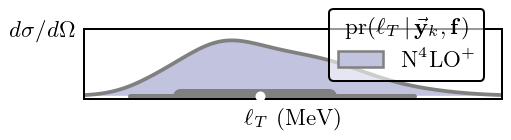

2024-11-20 16:34:43,911	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lstlab: MAP value = 69.97595
Observable $d\sigma / d\Omega$, variable lstlab: mean = 70.87062232042761
Observable $d\sigma / d\Omega$, variable lstlab: std. dev. = 5.503055578002393


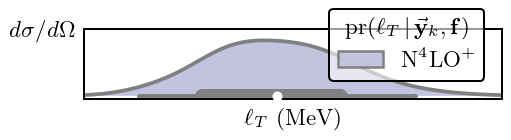

2024-11-20 16:34:55,356	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lstlab: MAP value = 69.67735
Observable $d\sigma / d\Omega$, variable lstlab: mean = 70.72574036378167
Observable $d\sigma / d\Omega$, variable lstlab: std. dev. = 5.248651100210414


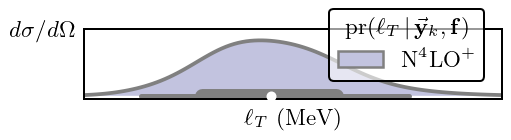

2024-11-20 16:35:07,173	INFO worker.py:1553 -- Started a local Ray instance.


Observable $d\sigma / d\Omega$, variable lstlab: MAP value = 72.06613
Observable $d\sigma / d\Omega$, variable lstlab: mean = 72.43726779256906
Observable $d\sigma / d\Omega$, variable lstlab: std. dev. = 5.548479707128852


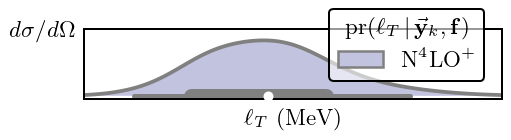

In [31]:
# calculates posterior pdfs for the lab-energy length scale and extracts values for 
# the MAP, mean, and variance
for degfp in degrees_slice_pts:
    ratio_fn=ratio_fn_new
    ratio_fn_kwargs={
        "p_param": p_type,
        "Q_param": Q_type,
        "p" : E_to_p(t_lab_slice_pts, interaction = 'np'),
        "mpi_var": mpi_eff_coeffs,
        "lambda_var": Lambda_b_coeffs,
        "single_expansion": False,
    }
    log_likelihood_fn=log_likelihood_new
    log_likelihood_fn_kwargs={
        "p_param": p_type,
        "Q_param": Q_type,
        "p" : E_to_p(t_lab_slice_pts, interaction = 'np'),
        "mpi_var": mpi_eff_coeffs,
        "lambda_var": Lambda_b_coeffs,
        "single_expansion": False,
    }
    
    stats_array, _ = generate_posteriors(
        scale_scheme_bunch_array=ScaleSchemeQ_list,
        Q_param_method_array=[Q_type],
        p_param_method_array=[p_type],
        input_space_deg=[degrees_name],
        input_space_tlab=[t_lab_name],
        deg_slice = degfp,
        t_lab_train_pts=t_lab_slice_pts,
        degrees_train_pts=np.array([41, 60, 76, 90, 104, 120, 139]),
        orders_from_ho=orders_ell,
        orders_excluded=[],
        orders_names_dict=None,
        orders_labels_dict=None,
        length_scale_list=[NSKernelParam(60, [10, 200])],
        length_scale_fixed = False,
        cbar_list = [NSKernelParam(1.0, [0.1, 10])],
        cbar_fixed = True,
        m_pi_eff=mpi_eff_coeffs,
        Lambdab=Lambda_b_coeffs,
        print_all_classes=False,
        savefile_type="png",

        plot_posterior_curvewise_bool=True,
        plot_marg_curvewise_bool=True,
        plot_corner_curvewise_bool=False,
        use_data_curvewise_bool=False,
        save_data_curvewise_bool=False,
        save_posterior_curvewise_bool=False,

        plot_obs_list = plot_obs_list,
        obs_name_grouped_list = obs_name_grouped_list,
        obs_labels_grouped_list = obs_labels_grouped_list,
        mesh_cart_grouped_list = mesh_cart_grouped_list,
        variables_array_curvewise = variables_array,
        
        ratio_fn_posterior = ratio_fn,
        ratio_fn_kwargs_posterior = ratio_fn_kwargs,
        log_likelihood_fn_posterior = log_likelihood_fn,
        log_likelihood_fn_kwargs_posterior = log_likelihood_fn_kwargs,
        
        cbar_fn = cbar_fn,
        cbar_fn_kwargs = cbar_fn_kwargs,
        scaling_fn = scaling_fn,
        scaling_fn_kwargs = scaling_fn_kwargs,

        plot_posterior_pointwise_bool=False,
        save_posterior_pointwise_bool=False,

        variables_array_pointwise = np.array([0]),

        filename_addendum="",
    )

    ell_fit_pts = np.append(ell_fit_pts, stats_array[[i % 3 == 0 for i in range(np.shape(stats_array)[0])]])
    ell_fit_stddev = np.append(ell_fit_stddev, stats_array[[i % 3 == 2 for i in range(np.shape(stats_array)[0])]])

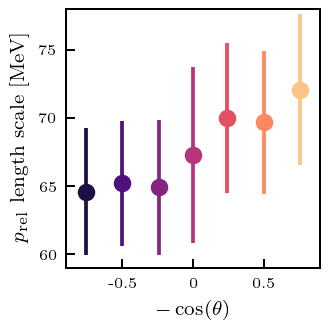

In [32]:
from sklearn.linear_model import LinearRegression

# dicts for orders
orders_labels_dict = {6: r'N$^{4}$LO+', 5: r'N$^{4}$LO',
                    4: r'N$^{3}$LO', 3: r'N$^{2}$LO', 2: r'NLO'}
orders_names_dict = {6: r'N4LO+', 5: r'N4LO', 4: r'N3LO', 3: r'N2LO', 2: r'NLO'}

for ss_idx in range(len(ScaleSchemeQ_list)):
    # create figure with n_orders subplots
    fig_deg_ls_all, axs_deg_ls_all = plt.subplots(1, 1, sharex = True, sharey=True, 
                                                  figsize=(2.0, 2.0))
    
    # sets axis limits, labels, and ticks
    axs_deg_ls_all.set_xlim(-0.9, 0.9)
    axs_deg_ls_all.set_xlabel(degrees_label, size = 8)
    axs_deg_ls_all.set_xticks(ticks = [-0.5, 0, 0.5], 
               labels = [-0.5, 0, 0.5], 
               fontsize=6)
    axs_deg_ls_all.set_ylim(59, 78)
    axs_deg_ls_all.set_ylabel(t_lab_label + ' length scale' + ' [MeV]', size = 8)
    axs_deg_ls_all.set_yticks(ticks = [60, 65, 70, 75], 
               labels = [60, 65, 70, 75], 
               fontsize=6)
#     axs_deg_ls_all.set_title('All-orders length scales for ' + obs_labels_grouped_list[0] + " (" + 
#                  ScaleScheme.potential_string + " " + 
#                  ScaleScheme.cutoff_string.replace("p", ".").replace("MeV", " MeV").replace("fm", " fm") + ")", size = 8)
    # axs_deg_ls_all.semilogx()
    # axs_deg_ls_all.semilogy()

    for o_idx in range(orders_ell):
        idx_mask = [i % (orders_ell * len(ScaleSchemeQ_list)) == 
                 (o_idx + ss_idx * orders_ell) for i in range(len(ell_fit_pts))]

        for d in degrees_subset:
            # scatter-plots the means and (1-sigma) confidence intervals for the length scale
            axs_deg_ls_all.errorbar(d, 
                        ell_fit_pts[idx_mask][np.isin(degrees_subset, d)], 
                        yerr = ell_fit_stddev[idx_mask][np.isin(degrees_subset, d)],
                        c = mpl.cm.ScalarMappable(norm=norm_deg, cmap=cmap_deg).to_rgba(d),
                        fmt = 'o', 
                       zorder = o_idx)
        
    fig_deg_ls_all.tight_layout()
    # saves figure
    fig_deg_ls_all.savefig('figures2/' + 'ls' + '_' + 'deg_slices' + '_' + 'allorders' + '_' +
                    ScaleScheme.potential_string + ScaleScheme.cutoff_string + '_' +
                    obs_name_grouped_list[0] + '_Q' + Q_type + '_' + p_type + '_' + t_lab_name + '_' + 
                    degrees_name)

## Plots $Q$ as a constant at different slices in momentum and fits to linear curve

In this section, the same analysis as in Fig. 7 of _Assessing Correlated Truncation Errors in Modern Nucleon-Nucleon Potentials_ is performed for other potentials.

2024-11-20 16:35:19,221	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.24232323
Observable Obs., variable Q: mean = 0.24364375320891224
Observable Obs., variable Q: std. dev. = 0.005977614214516567


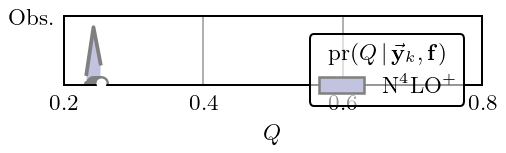

2024-11-20 16:35:47,212	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.2928283
Observable Obs., variable Q: mean = 0.2963287689416157
Observable Obs., variable Q: std. dev. = 0.009368233860685289


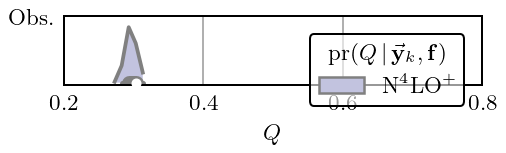

2024-11-20 16:36:14,109	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.32313132
Observable Obs., variable Q: mean = 0.3256354543588367
Observable Obs., variable Q: std. dev. = 0.009143220593991917


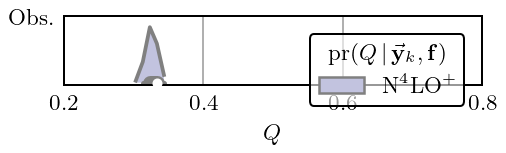

2024-11-20 16:36:42,299	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.3332323
Observable Obs., variable Q: mean = 0.3356955391947379
Observable Obs., variable Q: std. dev. = 0.009821763916107703


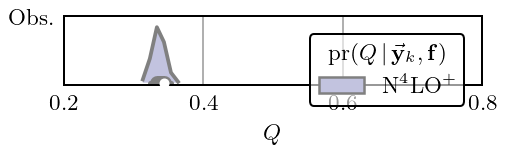

2024-11-20 16:37:10,296	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.36353534
Observable Obs., variable Q: mean = 0.35989207516030924
Observable Obs., variable Q: std. dev. = 0.011492467687130225


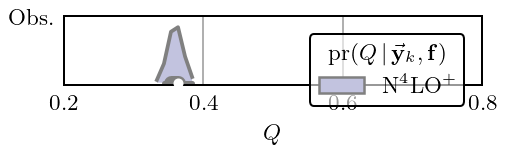

2024-11-20 16:37:38,239	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.39383838
Observable Obs., variable Q: mean = 0.391957799233701
Observable Obs., variable Q: std. dev. = 0.012967827860193442


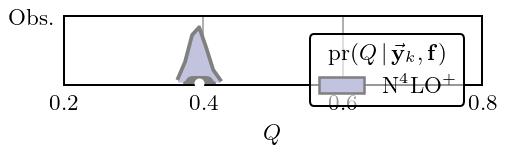

2024-11-20 16:38:07,413	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.41404042
Observable Obs., variable Q: mean = 0.4151968707623981
Observable Obs., variable Q: std. dev. = 0.014140095316316818


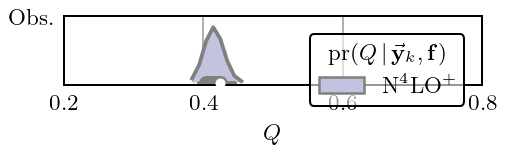

2024-11-20 16:38:35,467	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.43424243
Observable Obs., variable Q: mean = 0.4348938716343726
Observable Obs., variable Q: std. dev. = 0.014000319833628065


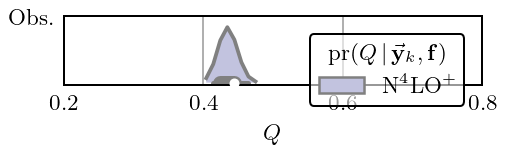

2024-11-20 16:39:04,253	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.46454546
Observable Obs., variable Q: mean = 0.4642376685926921
Observable Obs., variable Q: std. dev. = 0.014580509016496192


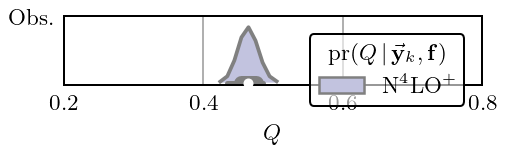

2024-11-20 16:39:33,407	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.47464648
Observable Obs., variable Q: mean = 0.4799608103508783
Observable Obs., variable Q: std. dev. = 0.016397929193113


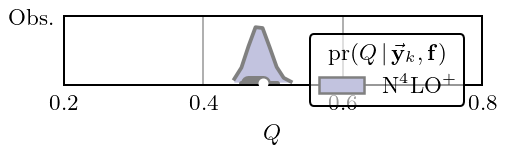

2024-11-20 16:40:02,606	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.4948485
Observable Obs., variable Q: mean = 0.49190522147460386
Observable Obs., variable Q: std. dev. = 0.01697684404073451


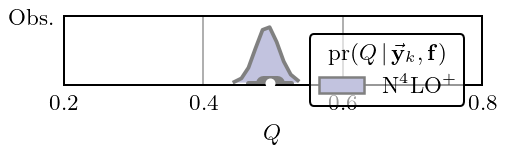

2024-11-20 16:40:31,867	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.5251515
Observable Obs., variable Q: mean = 0.5214222937285012
Observable Obs., variable Q: std. dev. = 0.018782915493929284


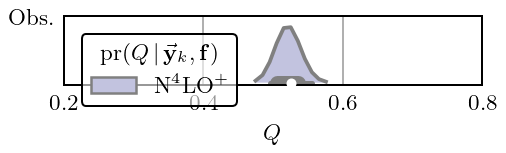

2024-11-20 16:41:01,139	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.54535353
Observable Obs., variable Q: mean = 0.5495444242253626
Observable Obs., variable Q: std. dev. = 0.02011448604989059


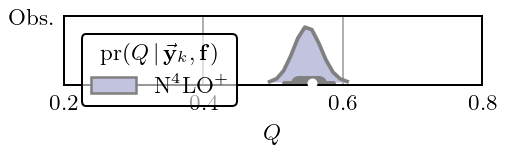

2024-11-20 16:41:30,410	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.5756566
Observable Obs., variable Q: mean = 0.5735607747164714
Observable Obs., variable Q: std. dev. = 0.02046004552568438


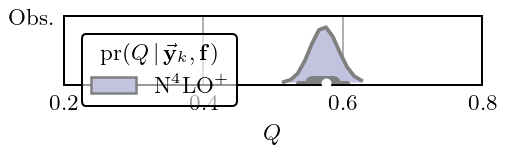

2024-11-20 16:41:59,625	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.5958586
Observable Obs., variable Q: mean = 0.5966339622183864
Observable Obs., variable Q: std. dev. = 0.020696060137969357


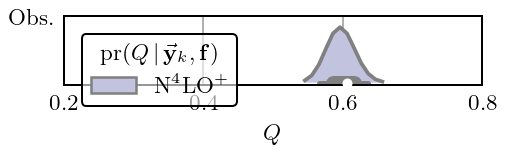

2024-11-20 16:42:28,731	INFO worker.py:1553 -- Started a local Ray instance.


Observable Obs., variable Q: MAP value = 0.6160606
Observable Obs., variable Q: mean = 0.6195426009241733
Observable Obs., variable Q: std. dev. = 0.021258922361654015


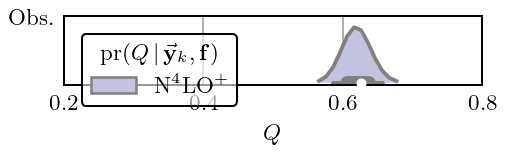

In [33]:
# ScaleSchemeQ_list = [EMN450MeV, EMN500MeV, EMN550MeV]
# ScaleSchemeQ_list = [EKM0p8fm, EKM0p9fm, EKM1p0fm, EKM1p1fm, EKM1p2fm]
# ScaleSchemeQ_list = [GT1p2fm, GT1p1fm, GT1p0fm, GT0p9fm]
# ScaleSchemeQ_list = [RKE550MeV, RKE500MeV, RKE450MeV, RKE400MeV]
ScaleSchemeQ_list = [RKE500MeV]

# fixed values of relative momentum where fitting will take place
Elab_fit_pts = np.array([1, 5, 12, 21, 
                         33, 48, 65, 85, 
                         108, 133, 161, 192, 
                         225, 261, 300, 341])
prel_fit_pts = E_to_p(E_lab = Elab_fit_pts, interaction = "np")

ls_deg_vals = np.linspace(0.01, 4, 100, dtype=np.dtype('f4'))
q_vals = np.linspace(0.01, 1.01, 100, dtype=np.dtype('f4'))

mesh_cart_q = gm.cartesian(q_vals, np.log(ls_deg_vals))

QVariable = RandomVariable(var=q_vals,
                                user_val=0.3,
                                name='Q',
                                label="Q",
                                units="",
                                ticks=[0.2, 0.4, 0.6, 0.8],
                                logprior=np.zeros(len(q_vals)),
                                logprior_name="noprior",
                                marg_bool=True)
LsDegVariable = RandomVariable(var=ls_deg_vals,
                               user_val=None,
                               name='lsdeg',
                               label="\ell_{\Theta}",
                               units="",
                               ticks=[],
                               logprior=np.zeros(len(ls_deg_vals)),
                               logprior_name="noprior",
                               marg_bool=False)
variables_array = np.array([QVariable, LsDegVariable])

# ALLOBS for angle input spaces
plot_obs_list = [["DSG", "D", "AXX", "AYY", "A", "AY"]]
obs_name_grouped_list = ["ALLOBS"]
obs_labels_grouped_list = [r'Obs.']
mesh_cart_grouped_list = [[mesh_cart_q, mesh_cart_q, mesh_cart_q, mesh_cart_q,
                           mesh_cart_q, mesh_cart_q]]

ratio_fn = ratio_fn_constant
ratio_fn_kwargs = {
                  "Q" : 0.3
}
log_likelihood_fn = log_likelihood_const
log_likelihood_fn_kwargs = {}

Q_fit_pts = np.array([])
Q_fit_stddev = np.array([])

orders_q = 1

for elfp in Elab_fit_pts:
    stats_array, _ = generate_posteriors(
#         nn_interaction="np",
        scale_scheme_bunch_array=ScaleSchemeQ_list,
        Q_param_method_array=["sum"],
        p_param_method_array=["pprel"],
        input_space_deg=["cos"],
        input_space_tlab=["prel"],
        Elab_slice = elfp,
        t_lab_train_pts=np.array([1, 12, 33, 65, 108, 161, 225, 300]),
        degrees_train_pts=np.array([41, 60, 76, 90, 104, 120, 139]),
        orders_from_ho=orders_q,
        orders_excluded=[],
        orders_names_dict=None,
        orders_labels_dict=None,
        length_scale_list=[NSKernelParam(0.4, [0.05, 4])],
        length_scale_fixed = False,
        cbar_list = [NSKernelParam(1.0, [0.1, 10])],
        cbar_fixed = True,
        m_pi_eff=141,
        Lambdab=480,
        print_all_classes=False,
        savefile_type="png",
        
        plot_posterior_curvewise_bool=True,
        plot_marg_curvewise_bool=True,
        plot_corner_curvewise_bool=False,
        use_data_curvewise_bool=False,
        save_data_curvewise_bool=False,
        save_posterior_curvewise_bool=False,

        plot_obs_list = plot_obs_list,
        obs_name_grouped_list = obs_name_grouped_list,
        obs_labels_grouped_list = obs_labels_grouped_list,
        mesh_cart_grouped_list = mesh_cart_grouped_list,
        variables_array_curvewise = variables_array,
        
        ratio_fn_posterior = ratio_fn,
        ratio_fn_kwargs_posterior = ratio_fn_kwargs,
        log_likelihood_fn_posterior = log_likelihood_fn,
        log_likelihood_fn_kwargs_posterior = log_likelihood_fn_kwargs,

        plot_posterior_pointwise_bool=False,
        save_posterior_pointwise_bool=False,

        variables_array_pointwise = np.array([0]),

        filename_addendum="",
    )

    Q_fit_pts = np.append(Q_fit_pts, stats_array[[i % 3 == 0 for i in range(np.shape(stats_array)[0])]])
    Q_fit_stddev = np.append(Q_fit_stddev, stats_array[[i % 3 == 2 for i in range(np.shape(stats_array)[0])]])

N4LO+: Lambda_b = 777.2036646616019 +/- 17.549461701453005 MeV
N4LO+: m_eff = 237.9451308035851 +/- 10.165173122996256 MeV



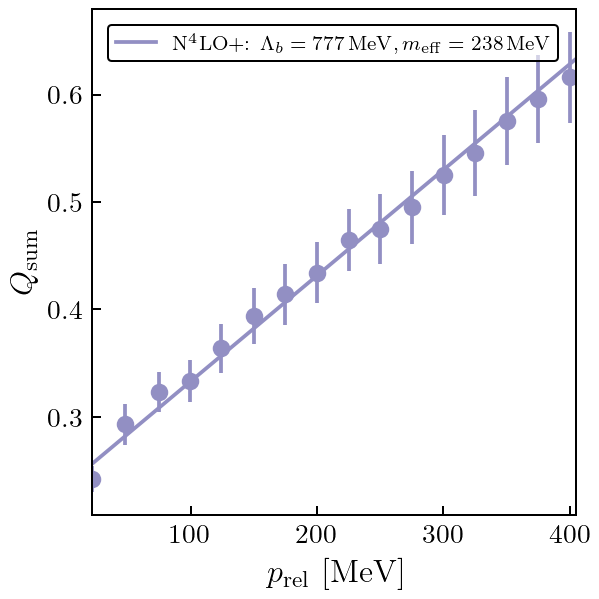

In [34]:
from sklearn.linear_model import LinearRegression

orders_labels_dict = {6: r'N$^{4}$LO+', 5: r'N$^{4}$LO',
                    4: r'N$^{3}$LO', 3: r'N$^{2}$LO', 2: r'NLO'}
orders_names_dict = {6: r'N4LO+', 5: r'N4LO', 4: r'N3LO', 3: r'N2LO', 2: r'NLO'}

def q_sum(x, lambda_b, m_pi):
        return (x + m_pi) / (m_pi + lambda_b)

for ss_idx in range(len(ScaleSchemeQ_list)):
    fig_fit, ax_fit = plt.subplots(figsize=(3.5,3.5))
    
    for o_idx in range(orders_q):
        idx_mask = [i % (orders_q * len(ScaleSchemeQ_list)) == 
                 (o_idx + ss_idx * orders_q) for i in range(len(Q_fit_pts))]

        # scatter-plots the means and 95% (2 sigma) confidence intervals for the N4LO+ Q posterior pdfs
        ax_fit.errorbar(prel_fit_pts, 
                        Q_fit_pts[idx_mask], 
                        yerr = 2 * Q_fit_stddev[idx_mask],
                        color = ScaleSchemeQ_list[ss_idx].cmaps[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx - 1](0.55), 
#                         label = r'$Q$', 
                        fmt = 'o', 
                       zorder = o_idx)
        # fits the points to a line
        popt, pcov = scipy.optimize.curve_fit(q_sum, prel_fit_pts, 
                                            Q_fit_pts[idx_mask], 
                                            sigma = Q_fit_stddev[idx_mask])
        # plots the line of best fit
        ax_fit.plot(E_to_p(E_lab = t_lab, interaction = 'np'), 
                    q_sum(E_to_p(E_lab = t_lab, interaction = 'np'), 
                          popt[0], popt[1]), 
                    color = ScaleSchemeQ_list[ss_idx].cmaps[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx - 1](0.55), 
                   label = orders_labels_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx + 1] + 
                    rf": $\Lambda_{{b}} = {popt[0]:3.0f}\,\mathrm{{MeV}}, m_{{\mathrm{{eff}}}} = {popt[1]:3.0f}\,\mathrm{{MeV}}$", 
                   zorder = o_idx)
        # prints the best fit values
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx + 1] + ": Lambda_b = " + str(popt[0]) + " +/- " + str(np.sqrt(pcov[0, 0])) + " MeV")
        print(orders_names_dict[len(ScaleSchemeQ_list[ss_idx].orders_full) - orders_q + o_idx + 1] + ": m_eff = " + str(popt[1]) + " +/- " + str(np.sqrt(pcov[1, 1])) + " MeV\n")

    # fig_fit.suptitle("MAP $Q$ values and lines of fit", fontsize = 20)
    ax_fit.set_xlabel("$p_{\mathrm{rel}}$ [MeV]", fontsize = 13)
    ax_fit.set_ylabel(r"$Q_{\mathrm{sum}}$", fontsize = 13)
    ax_fit.legend(fontsize = 8, loc = 'upper left')
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    fig_fit.tight_layout()

    fig_fit.savefig('figures2/' + 'qvsp_linear_' + 
        ScaleSchemeQ_list[ss_idx].potential_string + 
        ScaleSchemeQ_list[ss_idx].cutoff_string)